## Other Finemapping
Author: Frank Grenn and Hao Sun

### Load libraries

In [5]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(purrr)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [6]:
setwd("/restricted/projectnb/xqtl/xqtl_protocol/figures")
out <- "/restricted/projectnb/xqtl/jaempawi/xqtl_protocol"

In [7]:
source("utils.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ readr     2.1.6     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




## A. Using Fsusie

https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/AACS/07_epigenomic_QTL_and_their_target_regions.ipynb

possible candidates:  
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APP/07_epigenomic_QTL_and_their_target_regions.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/AC005670.2/07_epigenomic_QTL_and_their_target_regions.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ACADVL/07_epigenomic_QTL_and_their_target_regions.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ADAM10/07_epigenomic_QTL_and_their_target_regions.ipynb



In [8]:
gene_name = "ADAM10"

tar_gene_info <- get_gene_info(gene_name = gene_name)
gene_id <- tar_gene_info$gene_info$region_id

chrom = tar_gene_info$gene_info$'#chr'
print(chrom)
print(gene_id)

[1] "chr15"
[1] "ENSG00000137845"


### Step 1 : Download data

Data required:

s3://statfungen/ftp_fgc_xqtl/interactive_analysis/aw3600/case_example_codes/all_top_loci_except_fsusie_snATAC_multigene.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/finemapping_twas/fsusie/export/summary/FunGen_xQTL_epi.bulk.exported.bed.gz
s3://statfungen/ftp_fgc_xqtl/analysis_result/finemapping_twas/fsusie/export/summary/FunGen_xQTL_epi.bulk.exported.bed.gz.tbi
s3://statfungen/ftp_fgc_xqtl/analysis_result/snatac_fsusie/top_loci/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz
s3://statfungen/ftp_fgc_xqtl/analysis_result/snatac_fsusie/top_loci/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz.tbi

To download data, please follow steps here: https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ADAM10/01_fine_mapping_ADAM10.ipynb



In [9]:
# read flatten table
fla_tb <- readRDS('all_top_loci_except_fsusie_snATAC_multigene.rds')

In [10]:
head(fla_tb)

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,context,resource,lfsr,z
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,903284,903285,C,T,chr1:903285:T:C,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA
1,903351,903352,A,G,chr1:903352:G:A,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA
1,903509,903510,G,A,chr1:903510:A:G,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA
1,903535,903536,T,A,chr1:903536:A:T,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA
1,904080,904081,C,T,chr1:904081:T:C,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA
1,904114,904115,T,G,chr1:904115:G:T,ENSG00000235169,Knight_eQTL_brain_ENSG00000235169,0,0,0,0.04257485,-0.842082669467583,Knight_eQTL_brain,single_context,NA,NA


In [11]:
### Hao: This will retain all the rows that are variants from the eQTL of the said gene
fla_tb_extracted  = fla_tb%>%group_by(variant_ID)%>%filter(any(gene_ID == gene_id)) %>% filter(resource%in%c("single_context","AD_GWAS"))

### Hao: save also the variants that eQTL of the gene but not AD. It is still small enough
#fla_tb_extracted %>%ungroup%>% saveRDS(., paste0('Fungen_xQTL_allQTL.overlapped.gwas.export.',gene_name,'.rds'))

### Step 2 : Generate plots

following steps here: https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ADAM10/07_epigenomic_QTL_and_their_target_regions.ipynb

s3://statfungen/ftp_fgc_xqtl/interactive_analysis/aw3600/case_example_codes/all_top_loci_except_fsusie_snATAC_multigene.rds

In [12]:
flatten_table_fsusie = readRDS(paste0('Fungen_xQTL_allQTL.overlapped.gwas.export.',gene_name,'.rds'))
effect_table_bulk=  read_delim("FunGen_xQTL_epi.bulk.exported.bed.gz")
effect_table_snatac =  read_delim("ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz")

Rows: 234407 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): #chr, a1, a2, variant_ID, event_ID, region_ID, cs_id, cs_root, gri...
dbl  (8): start, end, maf, PIP, cs_coverage_0.95, TADB_start, TADB_end, grid...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 554 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): #chr, a1, a2, variant_ID, event_ID, region_ID, cs_id, cs_root, epi...
dbl  (8): start, end, TADB_start, TADB_end, maf, PIP, cs_coverage_0.95, grid...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### First see if there is AD sharing with epi-regional QTL with this gene


In [13]:
flatten_table_fsusie %>%
  group_by(`#chr`, end) %>%
  filter(any(str_detect(context, "mQTL") | str_detect(context, "haQTL") | str_detect(context, "snATA")), 
         any(str_detect(context, "AD_")))

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,context,resource,lfsr,z
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>


In [14]:
effect_table = bind_rows(effect_table_bulk,effect_table_snatac)

##### Check the epi-QTL that shared variants with an eQTL/sQTL/pQTL of this gene
The column n in the following table show the number of snp in the cs that are shared with the eQTL/sQTL/pQTL of our gene of interest, any QTL with the same ENSG ID will be considered

In [15]:
flatten_table_variants <- flatten_table_fsusie%>%filter(str_detect(gene_ID,"chr"))%>%summarize(max = max(end),min = min(end),chr = max( `#chr`)) 
flatten_table_variants

max,min,chr
<int>,<int>,<int>
58823796,58387188,15


In [16]:
effect_table%>%filter(variant_ID %in% flatten_table_fsusie$variant_ID)%>%count(event_ID)

event_ID,n
<chr>,<int>
KnightADRC_mQTL,4
MSBB_mQTL,2
ROSMAP_snATAC_Kelis_Oli,1


In [17]:
effect_of_interest = effect_table%>%filter(variant_ID %in% flatten_table_fsusie$variant_ID)%>%rename(context = event_ID,gene_ID = region_ID)

### Step 3 : Generate a crude plot to determined whether the story is interesting
This is a crude version of the case study plot which shows the

fsusie Effect (steelblue line), the gene body (black arrow), the epi-QTL (large steelblue dots), the epi marks (the black dots) and ADGWAS cs position (small red dots), x axis shows the genomics position of each plot, y axis shows estimated effect of the small dots and line, as well as PIP of the epigenetics-QTLs. Only the effect where the AD signal is covered is shown.

In [18]:
effect_of_interest_grid = effect_of_interest %>%
    separate_rows(grid_positions, grid_effects, sep = ";")%>%select(-epi_mark_positions,-epi_mark_names ,-epi_mark_effects )%>%
    mutate(grid_positions = as.numeric(grid_positions),
           grid_effects = as.numeric(grid_effects),
           cs_coverage_0.95 = as.character(cs_coverage_0.95))%>%na.omit

In [19]:
effect_of_interest_mark  = effect_of_interest %>%select(-grid_positions,-grid_effects )%>%
    separate_rows(epi_mark_positions,epi_mark_names ,epi_mark_effects , sep = ";")%>%
    mutate(epi_mark_positions = as.numeric(epi_mark_positions),
           epi_mark_effects = as.numeric(epi_mark_effects),
           cs_coverage_0.95 = as.character(cs_coverage_0.95))%>%na.omit

In [20]:
all_pos = c(flatten_table_fsusie%>%filter( str_detect(context,"AD_"), cs_coverage_0.95 != 0  )%>%pull(end),
tar_gene_info$gene_info$gene_start,tar_gene_info$gene_info$gene_end)
keys <- effect_of_interest_grid %>% distinct(cs_id, context, gene_ID)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


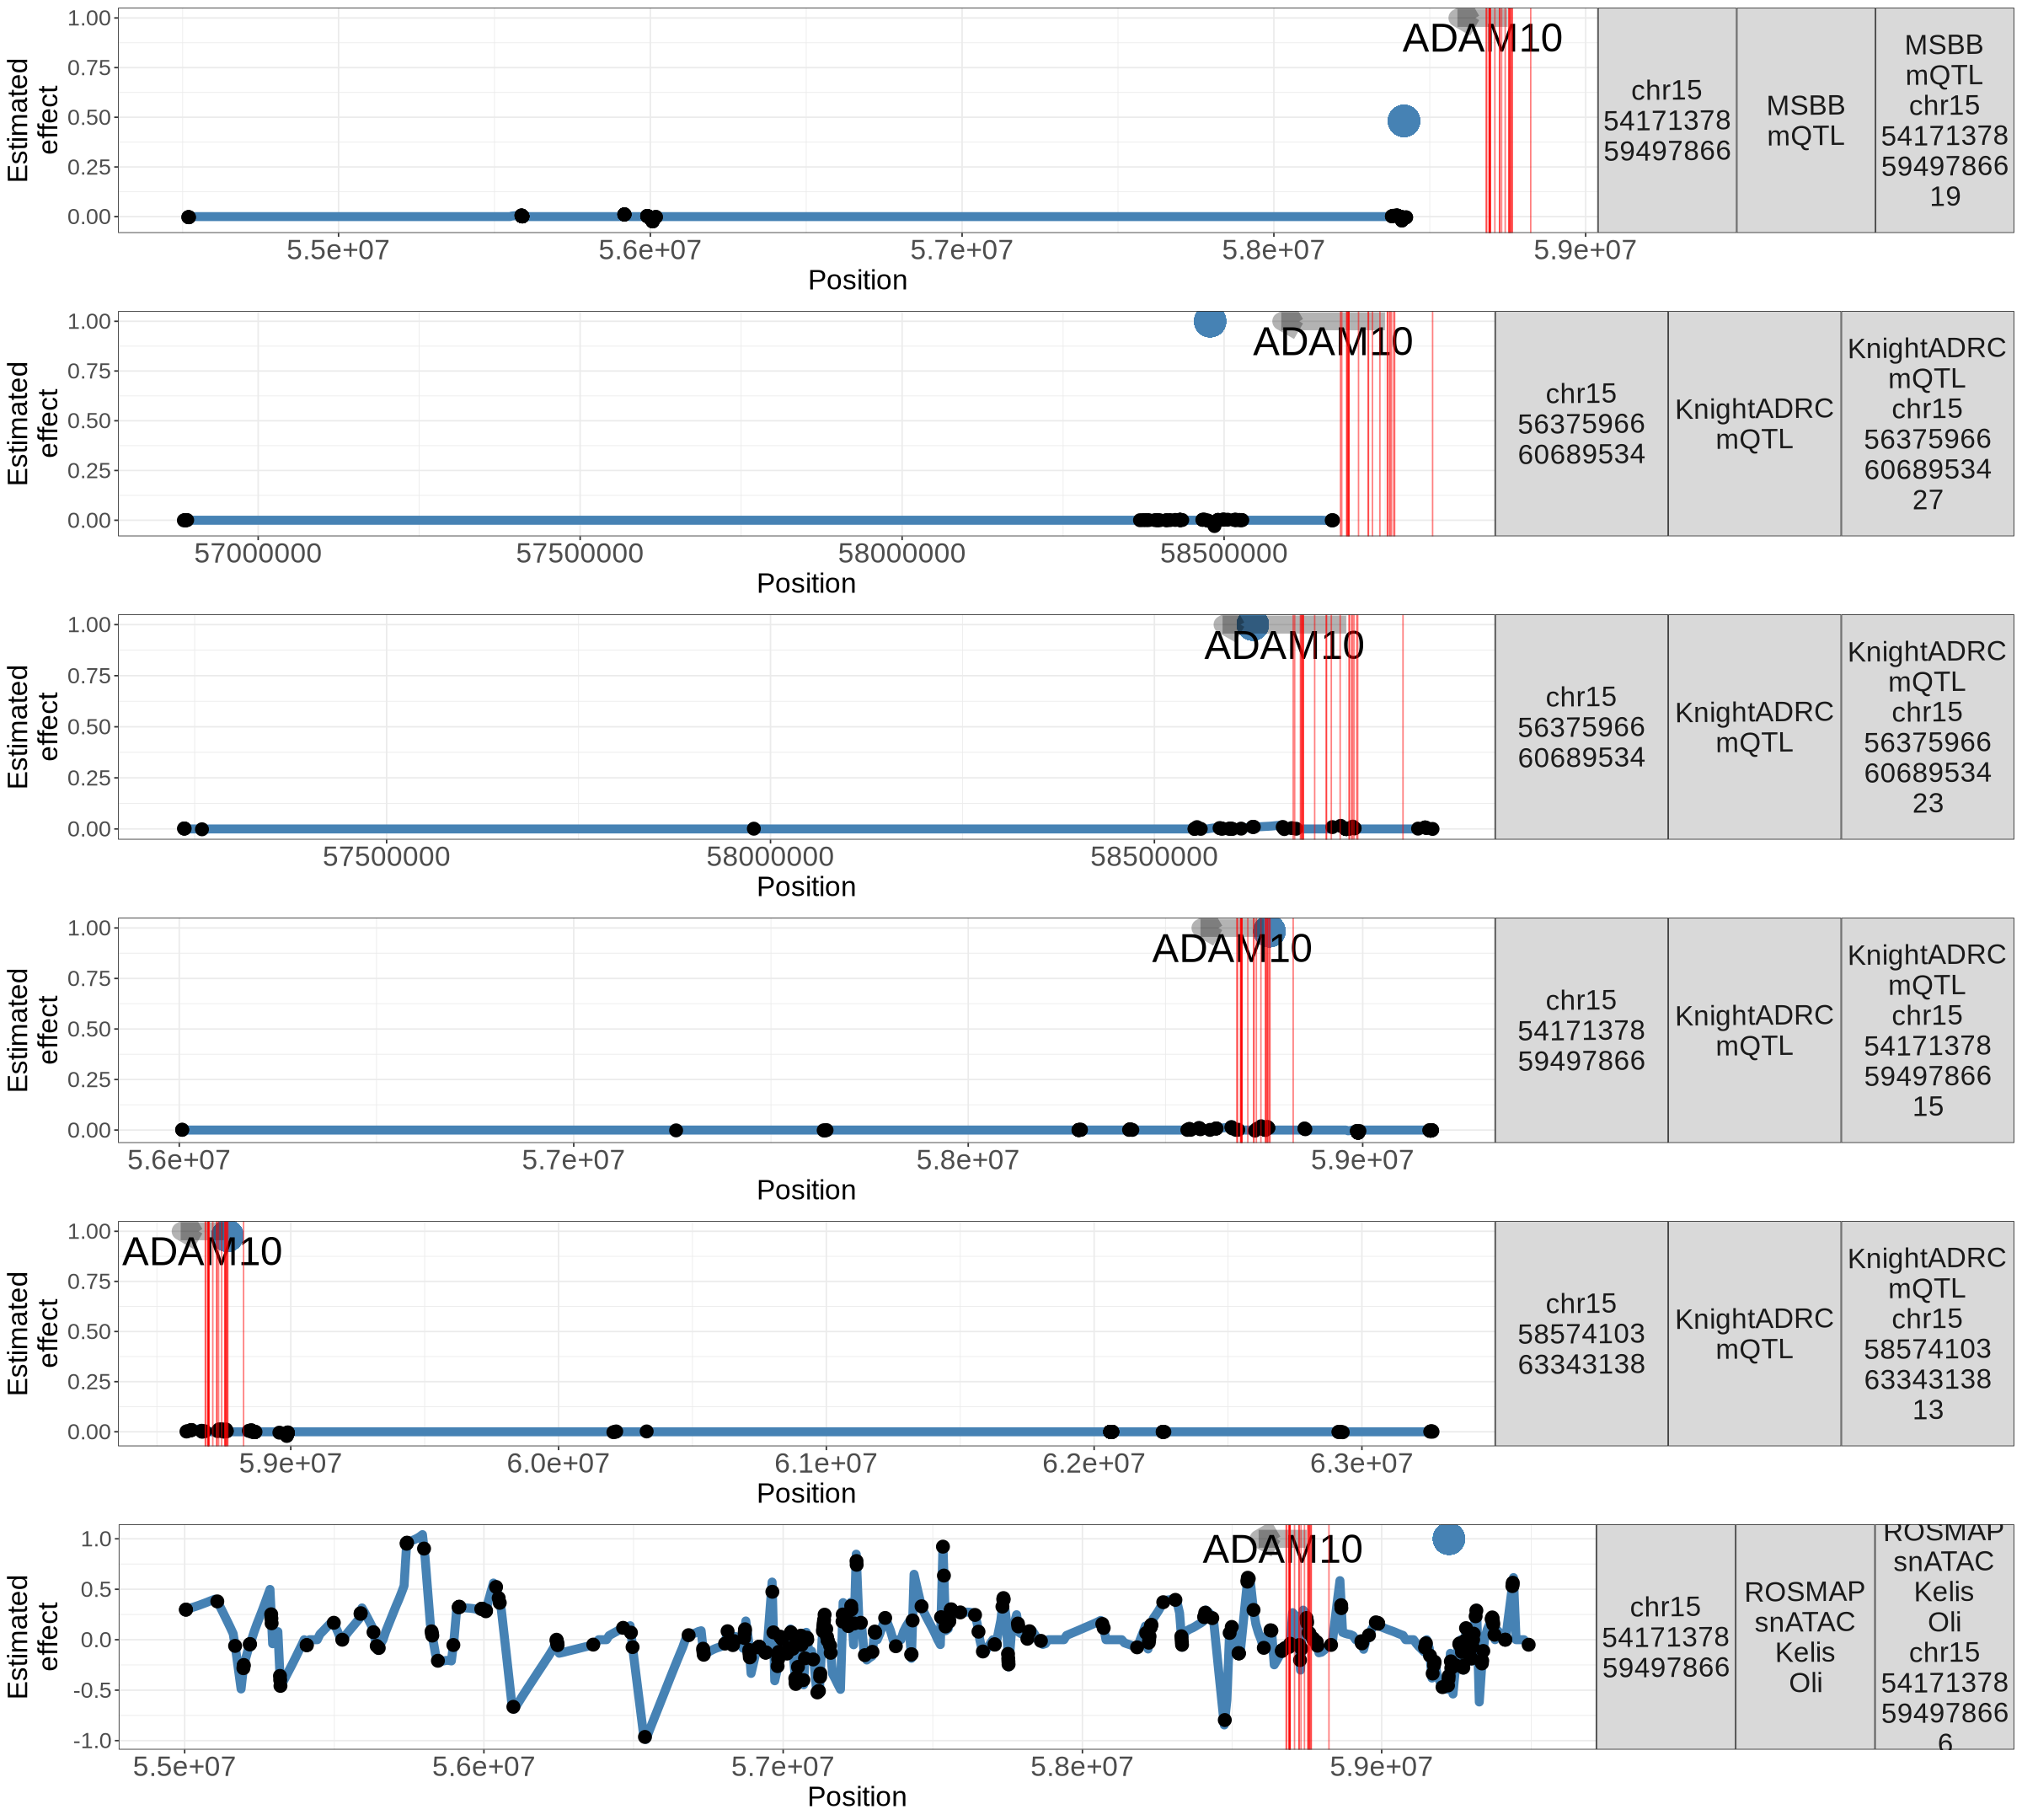

In [21]:
options(repr.plot.width = 20, repr.plot.height = 3*lengths(keys))

plots <- pmap(keys, function( cs_id, context, gene_ID) {
    cs_id1 = cs_id
  d_grid <- filter(effect_of_interest_grid, cs_id==cs_id1, context==context, gene_ID==gene_ID)
  d_mark <- filter(effect_of_interest_mark, cs_id==cs_id1, context==context, gene_ID==gene_ID)
  ginfo  <- filter(tar_gene_info$gene_info, gene_ID==gene_ID)
  vlines <- flatten_table_fsusie%>%filter( str_detect(context,"AD_") , cs_coverage_0.95 != 0  )%>%
                                   mutate(AD_context = context%>%str_replace_all("_","\n" ))%>%select(-context,-gene_ID,-cs_coverage_0.95) 
  ggplot() + facet_grid(cs_id + context + gene_ID ~ ., labeller = labeller(.rows = function(x) gsub("([_:,-])", "\n", x)), scale = "free_y") +
    geom_line(data=d_grid, aes(grid_positions, grid_effects, col=cs_coverage_0.95), size=3,,color = "steelblue") +
    geom_point(data=d_mark, aes(epi_mark_positions, epi_mark_effects), color="black", size=4) +
    geom_point(data=d_grid, aes(end, PIP, col=cs_coverage_0.95), size=10,color = "steelblue") +
    geom_segment(data=ginfo, aes(x=gene_start, xend=gene_end, y=1, yend=1),
                 arrow=arrow(length=unit(0.5, "cm")), size=6, alpha=0.3) +
    geom_text(data=ginfo, aes((gene_start+gene_end)/2, 0.9, label=gene_name), size=10) +
    geom_vline(data=vlines, aes(xintercept=end), color="red", alpha=0.5) +
    theme_bw() +
    theme(text = element_text(size = 20), strip.text.y = element_text(size = 20, angle = 0.5), 
            axis.text.x = element_text(size = 20), axis.title.x = element_text(size = 20)) +    labs(x="Position", y="Estimated\neffect")
})

p1 <- cowplot::plot_grid(plotlist=plots, ncol=1)
p1
                        

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Duplicated aesthetics after name standardisation: colour”


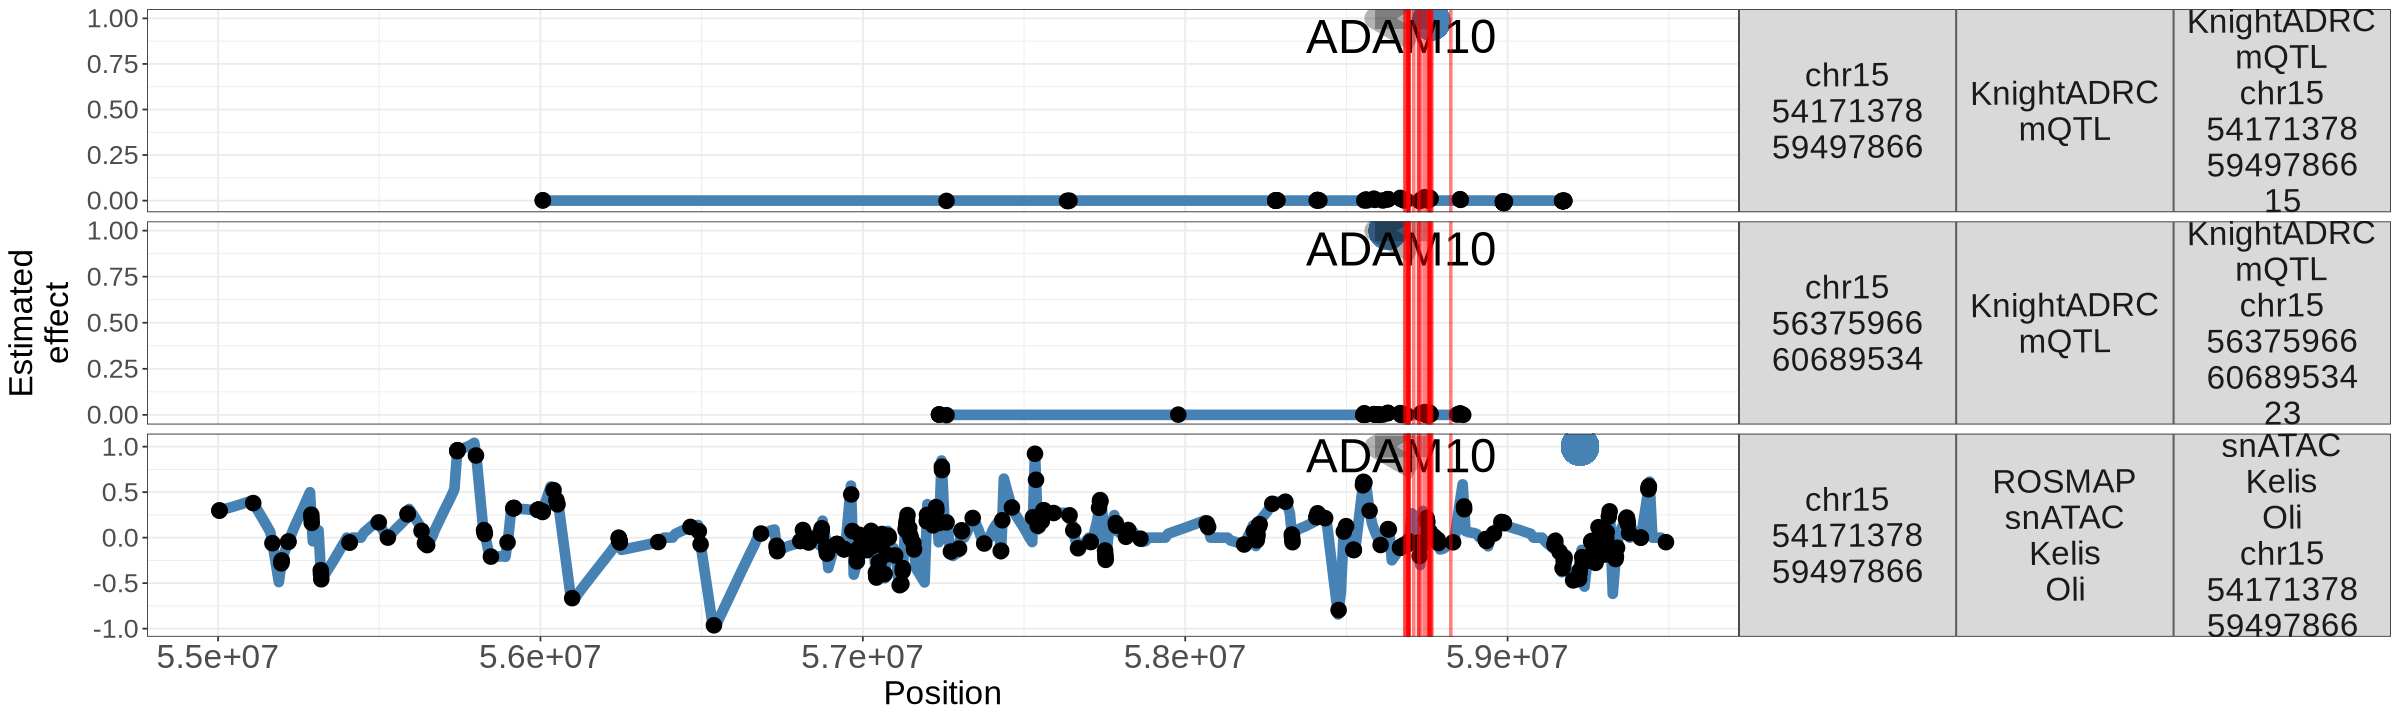

In [22]:
effect_of_interest_grid_filtered = effect_of_interest_grid%>%group_by(cs_id)%>%filter(min(grid_positions) < min(all_pos), max(grid_positions) > max(all_pos))
effect_of_interest_mark_filtered = effect_of_interest_mark%>%filter(cs_id %in% effect_of_interest_grid_filtered$cs_id )


p2 <- ggplot() + theme_bw() + facet_grid(cs_id + context + gene_ID ~ ., labeller = labeller(.rows = function(x) gsub("([_:,-])", "\n", x)), scale = "free_y") +

     # xlim(view_win) +
      ylab("Estimated effect") +
    geom_line(data = effect_of_interest_grid_filtered,
                aes_string(y = "grid_effects", x = "grid_positions"), color = "steelblue",size = 3) +  
        geom_point(data = effect_of_interest_mark_filtered,color = "black",
                aes_string(y = "epi_mark_effects", x = "epi_mark_positions"),color = "steelblue", size = 4) +  
    geom_point(data = effect_of_interest_grid_filtered,
                aes_string(y = "PIP", x = "end"),color = "steelblue", size = 10) +
    theme(text = element_text(size = 20), strip.text.y = element_text(size = 20, angle = 0.5), 
            axis.text.x = element_text(size = 20), axis.title.x = element_text(size = 20)) +
      xlab("Position") +
      ylab("Estimated\neffect") +
      geom_segment(arrow = arrow(length = unit(1, "cm")), aes(x = gene_start, xend = gene_end, y = 1, yend = 1), size = 6,
                  data = tar_gene_info$gene_info, alpha = 0.3) +
      geom_text(aes(x = (gene_start + gene_end) / 2, y = 0.9 , label = gene_name), size = 10, 
              data = tar_gene_info$gene_info)+
        geom_vline(aes(xintercept = end  ),size = 1,alpha = 0.5
                   ,color = "red", data = flatten_table_fsusie%>%filter( str_detect(context,"AD_") , cs_coverage_0.95 != 0  )%>%
                                   mutate(AD_context = context%>%str_replace_all("_","\n" ))%>%select(-context,-gene_ID,-cs_coverage_0.95) ) 

options(repr.plot.width = 20, repr.plot.height = 2* nrow(effect_of_interest_grid_filtered%>%count(cs_id , context , gene_ID )))
p2
#ggsave(paste0('3a_',gene_name,'.pdf'), width = 15, height = 7)

## B. Using MVSusiE

possible candidates:  
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APP/main_APP.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ACE/main_ACE.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APH1B/main_APH1B.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/CASS4/main_CASS4.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/CTSH/main_CTSH.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/NECTIN2/main_NECTIN2.ipynb
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/PRSS36/main_PRSS36.ipynb

files at:   
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_context/ROSMAP/mnm/ROSMAP_DeJager.chr16_ENSG00000178226.multicontext_bvsr.rds

In [23]:
gene_name = "PRSS36"
target_gene_info <- get_gene_info(gene_name = gene_name)
target_gene_info

$gene_info
         region_id   #chr    start     end      TSS
            <char> <char>    <num>   <num>    <int>
1: ENSG00000178226  chr16 28360000 3.4e+07 31150065
                                      LD_matrix_id
                                            <char>
1: chr16:26796952-29685831,chr16:29685831-46381513
                              LD_sumstats_id
                                      <char>
1: 16_26796952-29685831,16_29685831-46381513
                          LD_sumstats_id_old          TADB_index
                                      <char>              <char>
1: 16_26796952-29685831,16_29685831_46381513 TADB_1165,TADB_1166
                                           TADB_id gene_start gene_end
                                            <char>      <int>    <int>
1: chr16_27341433_34991551,chr16_30975802_46400000   31150066 31138926
                                                                                                           sliding_windows
                                                                                                                    <char>
1: chr16:21437007-30613717,chr16:22388493-34991551,chr16:24031743-46400000,chr16:27341433-49746318,chr16:30975802-50968730
   gene_name
      <char>
1:    PRSS36

$target_LD_ids
     [,1]                      [,2]                     
[1,] "chr16:26796952-29685831" "chr16:29685831-46381513"

$target_sums_ids
     [,1]                   [,2]                  
[1,] "16_26796952-29685831" "16_29685831-46381513"

$gene_region
[1] "chr16:28360000-3.4e+07"

$target_TAD_ids
     [,1]                      [,2]                     
[1,] "chr16_27341433_34991551" "chr16_30975802_46400000"

In [24]:
chrom = target_gene_info$gene_info$'#chr'
gene_id = target_gene_info$gene_info$region_id
print(chrom)
print(gene_id)

[1] "chr16"
[1] "ENSG00000178226"


In [25]:
multi_context_rosmap_tmp <- tryCatch(
    readRDS(paste0('ROSMAP_DeJager.',
                   chrom, '_', gene_id, '.multicontext_bvsr.rds')),
    error = function(e) message('Error in loading ROSMAP multi context data')
)

Multi context in ROSMAP data

Saving plot to: /restricted/projectnb/xqtl/jaempawi/xqtl_protocol/3b_PRSS36_pip.pdf

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the mvsusieR package.
  Please report the issue at <https://github.com/stephenslab/mvsusieR/issues>.”


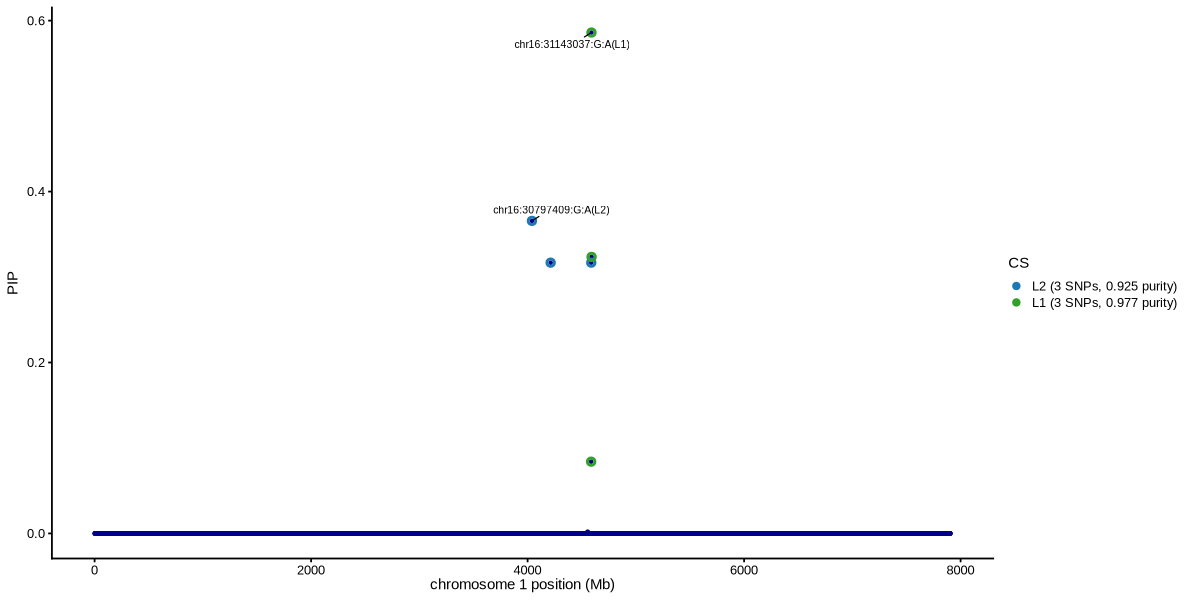

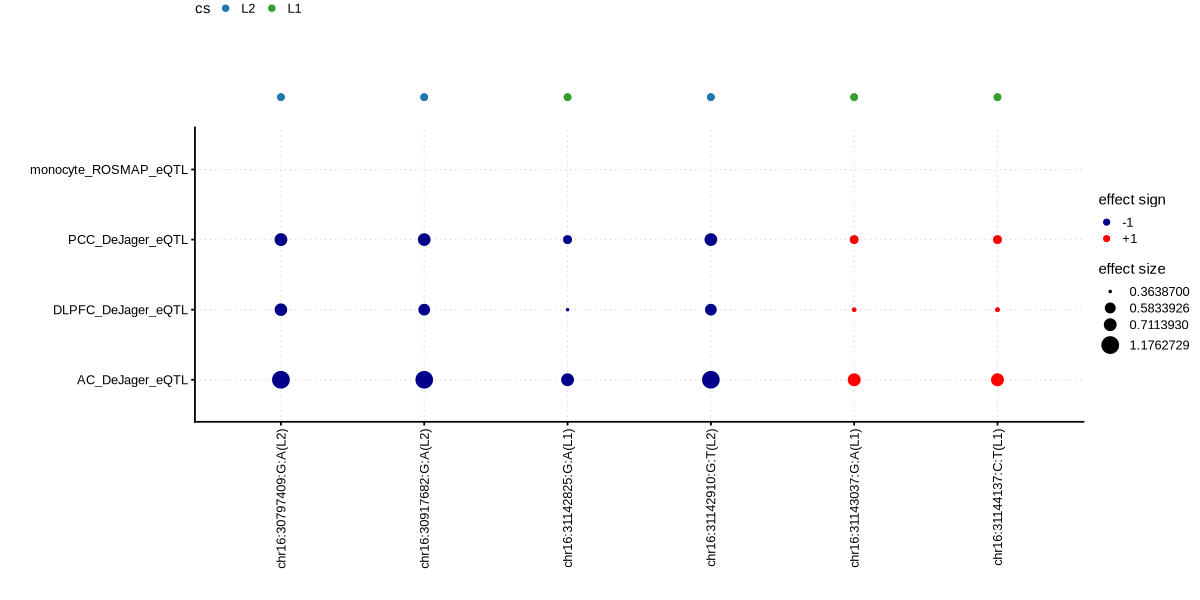

In [26]:
message("Multi context in ROSMAP data")
options(repr.plot.width = 10, repr.plot.height = 5)

multi_context_rosmap_tmp <- tryCatch(
    readRDS(paste0('ROSMAP_DeJager.', chrom, '_', gene_id, '.multicontext_bvsr.rds')),
    error = function(e) {
        message('Error in loading ROSMAP multi context data: ', e$message)
        return(NULL)
    }
)

if (!is.null(multi_context_rosmap_tmp) && !is.null(multi_context_rosmap_tmp[[1]]$mvsusie_fitted)) {
    # Create the full output path
    filename <- file.path(out, paste0('3b_', gene_name, '_pip.pdf'))
    
    # Ensure the output directory exists
    if (!dir.exists(out)) {
        dir.create(out, recursive = TRUE)
        message("Created output directory: ", out)
    }
    
    message("Saving plot to: ", filename)
    
    # Plot and save to the specified output directory
    plot_and_save(multi_context_rosmap_tmp[[1]], file.path(out, paste0('3b_', gene_name)))
} else {
    message('Multi Context results are empty in ROSMAP data')
}

## C. MASH (Constrast Matrix)

possible candidates:
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/PICALM/main_PICALM.ipynb

In [27]:
gene_name = "PICALM"
target_gene_info <- get_gene_info(gene_name = gene_name)
target_gene_info

$gene_info
         region_id   #chr    start      end      TSS
            <char> <char>    <num>    <num>    <int>
1: ENSG00000073921  chr11 84957175 87360000 86069881
                                      LD_matrix_id
                                            <char>
1: chr11:84267999-86714492,chr11:86714492-89332148
                              LD_sumstats_id
                                      <char>
1: 11_84267999-86714492,11_86714492-89332148
                          LD_sumstats_id_old
                                      <char>
1: 11_84267999-86714492,11_86714492_89332148
                                     TADB_index
                                         <char>
1: TADB_914,TADB_915,TADB_916,TADB_917,TADB_918
                                                                                                                   TADB_id
                                                                                                                    <char>
1: chr11_80821272_86627922,chr11_82455012_86627922,chr11_82455012_86627922,chr11_82455012_88330052,chr11_86037843_91192894
   gene_start gene_end
        <int>    <int>
1:   86069882 85957175
                                                                                                                                   sliding_windows
                                                                                                                                            <char>
1: chr11:77324757-86627922,chr11:80552225-86627922,chr11:80821272-88330052,chr11:82455012-91192894,chr11:82455012-94812378,chr11:86037843-97507574
   gene_name
      <char>
1:    PICALM

$target_LD_ids
     [,1]                      [,2]                     
[1,] "chr11:84267999-86714492" "chr11:86714492-89332148"

$target_sums_ids
     [,1]                   [,2]                  
[1,] "11_84267999-86714492" "11_86714492-89332148"

$gene_region
[1] "chr11:84957175-87360000"

$target_TAD_ids
     [,1]                      [,2]                     
[1,] "chr11_80821272_86627922" "chr11_82455012_86627922"
     [,3]                      [,4]                     
[1,] "chr11_82455012_86627922" "chr11_82455012_88330052"
     [,5]                     
[1,] "chr11_86037843_91192894"

In [28]:
chrom = target_gene_info$gene_info$'#chr'
gene_id = target_gene_info$gene_info$region_id
print(chrom)
print(gene_id)

[1] "chr11"
[1] "ENSG00000073921"


In [29]:
mash_p <- mash_plot(gene_name = gene_name,gene_id = gene_id,
                   raw_input_path = "mash_preprocessing.mash_input_extracted.rds", 
    input_path = "mash_preprocessing.mash_input_extracted.37context.20kvar.toadgwas.rds", 
    vhat_path = "adgwas_20k_prune37_ed_bovy_1e3.EZ.V_simple.rds", 
    U_path = "adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds", 
    mash_model_path = "adgwas_20k_prune37_ed_bovy_1e3.EZ.mash_model.rds"                  
                   )

options(repr.plot.width = 10, repr.plot.height = 10)

Loading data...

Loading mash model... (may take 2 mins)

MASH analysis on target variants



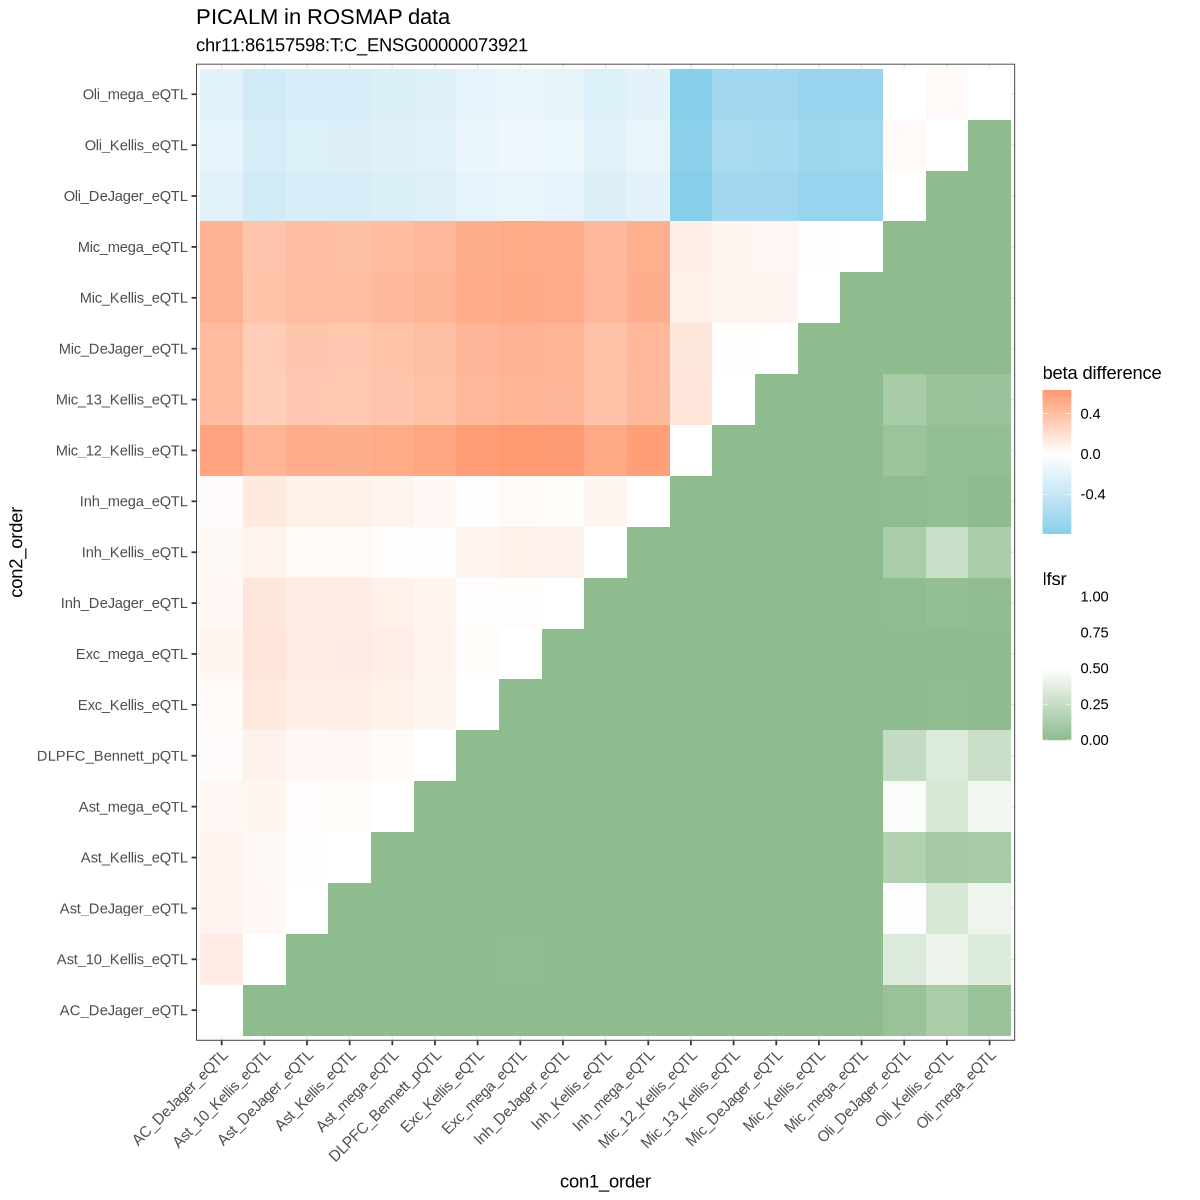

In [30]:
for (mash_p_tmp in mash_p) {
    print(mash_p_tmp)
    # Try to extract a name or identifier from the object
    obj_name <- if (!is.null(names(mash_p_tmp))) names(mash_p_tmp)[1] else 
                if (!is.null(rownames(mash_p_tmp))) rownames(mash_p_tmp)[1] else 
                deparse(substitute(mash_p_tmp))
    
    filename <- file.path(out, paste0('3c_', gene_name, '_sec4.mash_posterior_', obj_name, '.pdf'))
    ggsave(filename = filename, height = 6, width = 7)
}

In [31]:
mm <- readRDS('adgwas_20k_prune37_ed_bovy_1e3.EZ.mash_model.rds')
print(names(mm))
print(names(mm$mash_model))

[1] "mash_model" "vhat_file"  "prior_file"
[1] "result"            "loglik"            "vloglik"          
[4] "null_loglik"       "alt_loglik"        "fitted_g"         
[7] "posterior_weights" "alpha"             "lm"               


In [32]:
mm$prior_file

[1] "/mnt/vast/hpc/csg/rf2872/Work/Multivariate/MASH/2024_9/adgwas_20k_prune37_ed_bovy_1e3/adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds"

In [33]:
dim(mm$mash_model$posterior_weights)

[1] 184359    121

In [34]:
prior <- readRDS('adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds')
print(names(prior))

[1] "U"      "w"      "loglik"


In [35]:
prior$w

XtX       tFLASH_default      FLASH_default_1 
        4.623728e-02         1.396188e-01         3.557751e-03 
     FLASH_default_2      FLASH_default_3      FLASH_default_4 
        2.213242e-04         6.484347e-03         4.745994e-04 
     FLASH_default_5      FLASH_default_6      FLASH_default_7 
        1.800989e-03         9.343980e-03         5.822816e-17 
     FLASH_default_8      FLASH_default_9     FLASH_default_10 
        3.417942e-03         2.399652e-04         1.079457e-04 
    FLASH_default_11        tFLASH_nonneg       FLASH_nonneg_1 
        2.758505e-22         9.097110e-02         1.232811e-04 
      FLASH_nonneg_2       FLASH_nonneg_3       FLASH_nonneg_4 
        3.771657e-21         6.307821e-03         7.091882e-03 
      FLASH_nonneg_5       FLASH_nonneg_6       FLASH_nonneg_7 
        6.881576e-04         5.302527e-03         6.204808e-03 
      FLASH_nonneg_8       FLASH_nonneg_9      FLASH_nonneg_10 
        5.125562e-05         6.956576e-03         6.815336e-03 
     FLASH_nonneg_11      FLASH_nonneg_12                PCA_1 
        3.688110e-03         5.260710e-04         3.962760e-39 
               PCA_2                 tPCA             identity 
        3.122047e-75         2.535313e-03         1.732244e-01 
   Knight_eQTL_brain        MiGA_GFM_eQTL        MiGA_GTS_eQTL 
        5.580365e-03         1.978226e-02         4.188606e-02 
       MiGA_SVZ_eQTL        MiGA_THA_eQTL      BM_10_MSBB_eQTL 
        5.254750e-02         3.946213e-02         3.784209e-03 
     BM_22_MSBB_eQTL      BM_36_MSBB_eQTL      BM_44_MSBB_eQTL 
        4.897118e-03         6.186473e-03         3.310896e-03 
monocyte_ROSMAP_eQTL     Mic_DeJager_eQTL     Ast_DeJager_eQTL 
        1.958052e-02         2.344298e-03         1.864173e-03 
    Oli_DeJager_eQTL     Exc_DeJager_eQTL     Inh_DeJager_eQTL 
        1.730762e-03         9.627056e-04         1.085892e-03 
  DLPFC_DeJager_eQTL     PCC_DeJager_eQTL      AC_DeJager_eQTL 
        2.729139e-03         3.325088e-03         7.017447e-03 
     Mic_Kellis_eQTL      Ast_Kellis_eQTL      Oli_Kellis_eQTL 
        7.312028e-03         6.804415e-03         4.958830e-03 
     OPC_Kellis_eQTL      Exc_Kellis_eQTL      Inh_Kellis_eQTL 
        6.514165e-03         3.272026e-03         4.628046e-03 
       Ast_mega_eQTL        Exc_mega_eQTL        Inh_mega_eQTL 
        1.061478e-04         1.005995e-04         1.985228e-04 
       Oli_mega_eQTL     STARNET_eQTL_Mac   DLPFC_Bennett_pQTL 
        2.814233e-04         2.006466e-02         1.213092e-02 
    OPC_DeJager_eQTL        OPC_mega_eQTL   Ast_10_Kellis_eQTL 
        5.792239e-04         8.030386e-05         1.605363e-02 
  Mic_12_Kellis_eQTL   Mic_13_Kellis_eQTL        Mic_mega_eQTL 
        3.139000e-03         6.559844e-03         1.287465e-50 
        STARNET_eQTL        equal_effects         simple_het_1 
       1.662806e-249        8.945383e-205         1.122692e-01 
        simple_het_2         simple_het_3 
        4.760545e-02         7.273020e-03

In [36]:
names(prior$U)

[1] "XtX"                  "tFLASH_default"       "FLASH_default_1"     
 [4] "FLASH_default_2"      "FLASH_default_3"      "FLASH_default_4"     
 [7] "FLASH_default_5"      "FLASH_default_6"      "FLASH_default_7"     
[10] "FLASH_default_8"      "FLASH_default_9"      "FLASH_default_10"    
[13] "FLASH_default_11"     "tFLASH_nonneg"        "FLASH_nonneg_1"      
[16] "FLASH_nonneg_2"       "FLASH_nonneg_3"       "FLASH_nonneg_4"      
[19] "FLASH_nonneg_5"       "FLASH_nonneg_6"       "FLASH_nonneg_7"      
[22] "FLASH_nonneg_8"       "FLASH_nonneg_9"       "FLASH_nonneg_10"     
[25] "FLASH_nonneg_11"      "FLASH_nonneg_12"      "PCA_1"               
[28] "PCA_2"                "tPCA"                 "identity"            
[31] "Knight_eQTL_brain"    "MiGA_GFM_eQTL"        "MiGA_GTS_eQTL"       
[34] "MiGA_SVZ_eQTL"        "MiGA_THA_eQTL"        "BM_10_MSBB_eQTL"     
[37] "BM_22_MSBB_eQTL"      "BM_36_MSBB_eQTL"      "BM_44_MSBB_eQTL"     
[40] "monocyte_ROSMAP_eQTL" "Mic_DeJager_eQTL"     "Ast_DeJager_eQTL"    
[43] "Oli_DeJager_eQTL"     "Exc_DeJager_eQTL"     "Inh_DeJager_eQTL"    
[46] "DLPFC_DeJager_eQTL"   "PCC_DeJager_eQTL"     "AC_DeJager_eQTL"     
[49] "Mic_Kellis_eQTL"      "Ast_Kellis_eQTL"      "Oli_Kellis_eQTL"     
[52] "OPC_Kellis_eQTL"      "Exc_Kellis_eQTL"      "Inh_Kellis_eQTL"     
[55] "Ast_mega_eQTL"        "Exc_mega_eQTL"        "Inh_mega_eQTL"       
[58] "Oli_mega_eQTL"        "STARNET_eQTL_Mac"     "DLPFC_Bennett_pQTL"  
[61] "OPC_DeJager_eQTL"     "OPC_mega_eQTL"        "Ast_10_Kellis_eQTL"  
[64] "Mic_12_Kellis_eQTL"   "Mic_13_Kellis_eQTL"   "Mic_mega_eQTL"       
[67] "STARNET_eQTL"         "equal_effects"        "simple_het_1"        
[70] "simple_het_2"         "simple_het_3"

In [37]:
prior$loglik

[1] -66.45261 -61.82842 -60.95453 -60.77301 -60.67551 -60.59816 -60.53322
 [8] -60.47943 -60.43503 -60.39795 -60.36642 -60.33899 -60.31465 -60.29265
[15] -60.27172 -60.25052 -60.22888 -60.20904 -60.19224 -60.17813 -60.16598
[22] -60.15537 -60.14606 -60.13779 -60.13034 -60.12353 -60.11723 -60.11133
[29] -60.10576 -60.10044 -60.09533 -60.09041 -60.08566 -60.08106 -60.07659
[36] -60.07224 -60.06795 -60.06373 -60.05955 -60.05541 -60.05129 -60.04716
[43] -60.04299 -60.03875 -60.03440 -60.02989 -60.02523 -60.02053 -60.01596
[50] -60.01164 -60.00758 -60.00378 -60.00023 -59.99691 -59.99379 -59.99086
[57] -59.98808 -59.98543 -59.98291 -59.98049 -59.97819 -59.97601 -59.97393
[64] -59.97194 -59.97005 -59.96823 -59.96650 -59.96483 -59.96324 -59.96171
[71] -59.96023 -59.95881 -59.95744 -59.95611 -59.95483 -59.95358 -59.95236
[78] -59.95117 -59.95001 -59.94885 -59.94770 -59.94656 -59.94540 -59.94423
[85] -59.94303 -59.94179 -59.94049 -59.93910 -59.93759 -59.93596 -59.93428
[92] -59.93263 -59.93105 -59.92959 -59.92829 -59.92716 -59.92619

In [38]:
names(mm$mash_model)

[1] "result"            "loglik"            "vloglik"          
[4] "null_loglik"       "alt_loglik"        "fitted_g"         
[7] "posterior_weights" "alpha"             "lm"

In [39]:
mm$prior_file

[1] "/mnt/vast/hpc/csg/rf2872/Work/Multivariate/MASH/2024_9/adgwas_20k_prune37_ed_bovy_1e3/adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds"

### Generate the other prior matrix
The plot_U part from here: https://github.com/StatFunGen/xqtl-protocol/blob/main/code/multivariate_genome/MASH/mixture_prior.ipynb

code copied below for ease of use (with minor changes to syntax and parameters from sos notebook):

In [40]:
#data = path
# number of components to show
max_comp = -1
# whether or not to convert to correlation
to_cor = FALSE
tol = "1E-6"
remove_label = FALSE
name = ""

In [41]:
plot_sharing = function(X, col = 'black', to_cor=FALSE, title="", remove_names=F) {
    clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
        "#E0F3F8","#91BFDB","#4575B4")))(128)
    if (to_cor) lat <- cov2cor(X)
    else lat = X/max(diag(X))
    lat[lower.tri(lat)] <- NA
    n <- nrow(lat)
    if (remove_names) {
        colnames(lat) = paste('t',1:n, sep = '')
        rownames(lat) = paste('t',1:n, sep = '')
    }
    melted_cormat <- reshape2::melt(lat[n:1,], na.rm = TRUE)
    p = ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+ggtitle(title) + 
        scale_fill_gradientn(colors = clrs, limit = c(-1,1), space = "Lab") +
        theme_minimal()+ 
        coord_fixed() +
        theme(axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(color=col, size=8,angle=45,hjust=1),
              axis.text.y = element_text(color=rev(col), size=8),
              title =element_text(size=10),
              # panel.grid.major = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank(),
              axis.ticks = element_blank(),
              legend.justification = c(1, 0),
              legend.position = c(0.6, 0),
              legend.direction = "horizontal")+
        guides(fill = guide_colorbar(title="", barwidth = 7, barheight = 1,
               title.position = "top", title.hjust = 0.5))
    if(remove_names){
        p = p + scale_x_discrete(labels= 1:n) + scale_y_discrete(labels= n:1)
    }
    return(p)
}

8 components out of 71 total components have weight greater than 1E-6



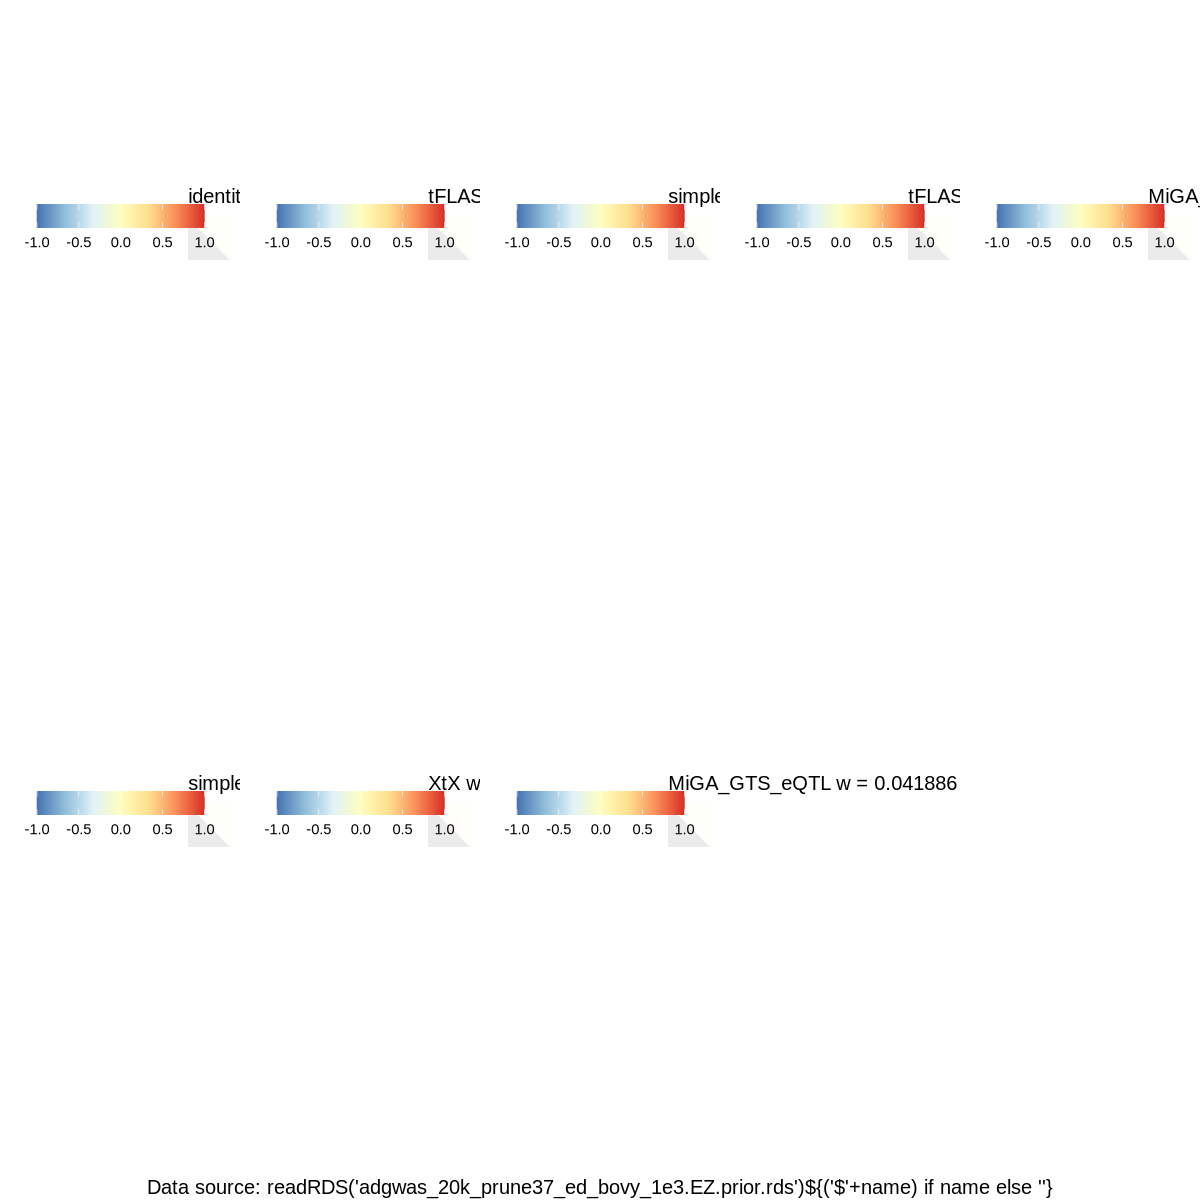

In [42]:
dat = readRDS("adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds")
name = "${name}"
#if (name != "") {
#  if (is.null(dat[[name]])) stop("Cannot find data ${name} in ${_input}")
#    dat = dat[[name]]
#}
if (is.null(names(dat$U))) names(dat$U) = paste0("Comp_", 1:length(dat$U))
meta = data.frame(names(dat$U), dat$w, stringsAsFactors=F)
colnames(meta) = c("U", "w")
#tol = ${tol}
n_comp = length(meta$U[which(meta$w>tol)])

if (max_comp <=1 ){
    max_comp = nrow(meta)
}
meta = head(meta[order(meta[,2], decreasing = T),], max_comp)
message(paste(n_comp, "components out of", length(dat$w), "total components have weight greater than", tol))
res = list()
for (i in 1:n_comp) {
    title = paste(meta$U[i], "w =", round(meta$w[i], 6))
    ##Handle updated udr data structure
    if(is.list(dat$U[[meta$U[i]]])){
      res[[i]] = plot_sharing(dat$U[[meta$U[i]]]$mat, to_cor , title=title, remove_names = remove_label)
    } else if(is.matrix(dat$U[[meta$U[i]]])){
      res[[i]] = plot_sharing(dat$U[[meta$U[i]]], to_cor , title=title, remove_names = remove_label)
    }
}
unit = 4
n_col = 5
n_row = ceiling(n_comp / n_col)
#pdf("3c_fig2_all.pdf", width = unit * n_col, height = unit * n_row)
do.call(gridExtra::grid.arrange, c(res, list(ncol = n_col, nrow = n_row, bottom = "Data source: readRDS('adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds')${('$'+name) if name else ''}")))
#dev.off()

8 components out of 71 total components have weight greater than 1E-6



[1] 1
[1] "identity w = 0.173224"
[1] 5
[1] "MiGA_SVZ_eQTL w = 0.052547"
[1] 6
[1] "simple_het_2 w = 0.047605"
[1] 7
[1] "XtX w = 0.046237"


TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name                 grob
1 1 (1-1,1-1) arrange       gtable[layout]
2 2 (1-1,2-2) arrange       gtable[layout]
3 3 (2-2,1-1) arrange       gtable[layout]
4 4 (2-2,2-2) arrange       gtable[layout]
5 5 (3-3,1-2) arrange text[GRID.text.1523]

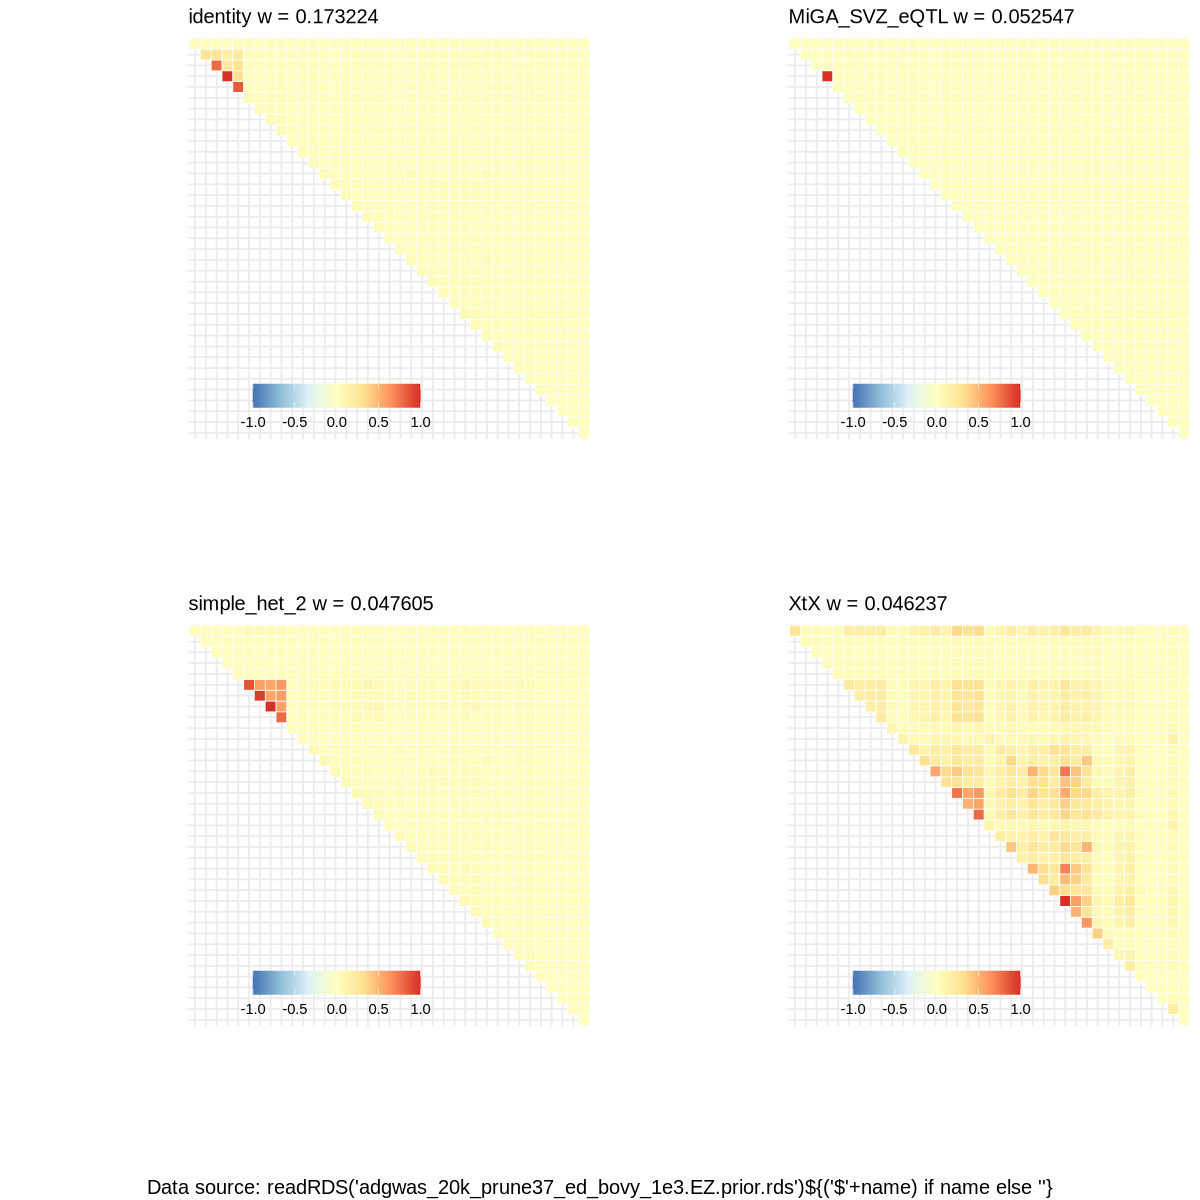

In [43]:
dat = readRDS("adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds")
name = "${name}"
#if (name != "") {
#  if (is.null(dat[[name]])) stop("Cannot find data ${name} in ${_input}")
#    dat = dat[[name]]
#}
if (is.null(names(dat$U))) names(dat$U) = paste0("Comp_", 1:length(dat$U))
meta = data.frame(names(dat$U), dat$w, stringsAsFactors=F)
colnames(meta) = c("U", "w")
#tol = ${tol}
n_comp = length(meta$U[which(meta$w>tol)])

if (max_comp <=1 ){
    max_comp = nrow(meta)
}
meta = head(meta[order(meta[,2], decreasing = T),], max_comp)
message(paste(n_comp, "components out of", length(dat$w), "total components have weight greater than", tol))
res = list()
subset = c(1,5,6,7)
count = 1
#for (i in 1:n_comp) {
for (i in subset) {
    print(i)
    title = paste(meta$U[i], "w =", round(meta$w[i], 6))
    print(title)
    ##Handle updated udr data structure
    if(is.list(dat$U[[meta$U[i]]])){
      res[[count]] = plot_sharing(dat$U[[meta$U[i]]]$mat, to_cor , title=title, remove_names = remove_label)
    } else if(is.matrix(dat$U[[meta$U[i]]])){
      res[[count]] = plot_sharing(dat$U[[meta$U[i]]], to_cor , title=title, remove_names = remove_label)
    }
    count = count + 1
}
unit = 4
#n_col = 5
#n_row = ceiling(n_comp / n_col)
n_col = 2
n_row = 2
#pdf("3c_fig2_subset.pdf", width = unit * n_col, height = unit * n_row)
p4 <- do.call(gridExtra::grid.arrange, c(res, list(ncol = n_col, nrow = n_row, bottom = "Data source: readRDS('adgwas_20k_prune37_ed_bovy_1e3.EZ.prior.rds')${('$'+name) if name else ''}")))
p4
#dev.off()

## D. Multigene Fine Mapping

possible candidates:  
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/ACE/main_ACE.ipynb  
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APH1B/main_APH1B.ipynb  
https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APP/main_APP.ipynb  

In [44]:
gene_name = "APH1B"
#last two multigene plots from above notebook for this gene

In [45]:
target_gene_info <- get_gene_info(gene_name = gene_name)
target_gene_info

$gene_info
         region_id   #chr    start      end      TSS
            <char> <char>    <num>    <num>    <int>
1: ENSG00000138613  chr15 62276017 65480000 63276017
                                      LD_matrix_id
                                            <char>
1: chr15:61125463-63051119,chr15:63051119-66680537
                              LD_sumstats_id
                                      <char>
1: 15_61125463-63051119,15_63051119-66680537
                          LD_sumstats_id_old                    TADB_index
                                      <char>                        <char>
1: 15_61125463-63051119,15_63051119_66680537 TADB_1132,TADB_1133,TADB_1134
                                                                   TADB_id
                                                                    <char>
1: chr15_58574103_63343138,chr15_60834681_64158021,chr15_61390525_66517704
   gene_start gene_end
        <int>    <int>
1:   63276018 63309126
                                                                                                                                                           sliding_windows
                                                                                                                                                                    <char>
1: chr15:54171378-63343138,chr15:56375966-64158021,chr15:58574103-66517704,chr15:60834681-67685794,chr15:61390525-69257131,chr15:64234460-70062762,chr15:65293216-73640125
   gene_name
      <char>
1:     APH1B

$target_LD_ids
     [,1]                      [,2]                     
[1,] "chr15:61125463-63051119" "chr15:63051119-66680537"

$target_sums_ids
     [,1]                   [,2]                  
[1,] "15_61125463-63051119" "15_63051119-66680537"

$gene_region
[1] "chr15:62276017-65480000"

$target_TAD_ids
     [,1]                      [,2]                     
[1,] "chr15_58574103_63343138" "chr15_60834681_64158021"
     [,3]                     
[1,] "chr15_61390525_66517704"

In [46]:
chrom = target_gene_info$gene_info$'#chr'
gene_id = target_gene_info$gene_info$region_id
print(chrom)
print(gene_id)

[1] "chr15"
[1] "ENSG00000138613"


### Generate the gene specific file like with part a above

In [47]:
# read flatten table
fla_tb <- readRDS('all_top_loci_except_fsusie_snATAC_multigene.rds')

In [48]:
### Hao: This will retain all the rows that are variants from the eQTL of the said gene
fla_tb_extracted  = fla_tb%>%group_by(variant_ID)%>%filter(any(gene_ID == gene_id)) %>% filter(resource%in%c("single_context","AD_GWAS"))

### Hao: save also the variants that eQTL of the gene but not AD. It is still small enough
#fla_tb_extracted %>%ungroup%>% saveRDS(., paste0('Fungen_xQTL_allQTL.overlapped.gwas.export.',gene_name,'.rds'))

### Following section 6 of https://github.com/StatFunGen/xqtl-alzheimer-genes/blob/main/AD_targets_automated/APH1B/main_APH1B.ipynb


#### Section 6: Context specific multi-gene fine-mapping
A quick analysis: using the xQTL-AD summary table (flatten table)
We extract from xQTL-AD summary table the variants to get other genes also have CS with the variants shared by target gene and AD.

In [49]:
flatten_tab <- "./Fungen_xQTL_allQTL.overlapped.gwas.export.APH1B.rds"
flatten_tab <- readRDS(flatten_tab)
flatten_tab <- flatten_tab%>%group_by(variant_ID)%>%filter(any(str_detect(context,"AD_") & cs_coverage_0.95!= 0 ))%>%ungroup %>% ## Hao: This ensure only the snp that overlapped with AD are ratained.
     filter(cs_coverage_0.95> 0 | cs_coverage_0.7 > 0| cs_coverage_0.5 > 0)

In [50]:
flatten_tab <- flatten_tab %>% filter(!str_detect(context, 'MSBB.+sQTL'))
multigene_flat <- get_multigene_flatten(flatten_tab)

In [51]:
fla_tb_reog <- flatten_tab %>% 
        filter(gene_ID != gene_id, !str_detect(context, '^AD')) %>% 
        #mutate(context = str_extract(study, "^.+QTL")) %>% 
        group_by(gene_ID) %>% 
        summarize(contexts = paste(unique(context), collapse = ','))

In [52]:
fla_tb_reog <- flatten_tab %>% 
        filter(gene_ID != gene_id, !str_detect(context, '^AD'))
fla_tb_reog

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,context,resource,lfsr,z
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>


In [53]:
multigene_flat

gene_id,#chr,start,end,gene_name
<chr>,<chr>,<int>,<int>,<chr>
ENSG00000138613,chr15,63276017,63276018,APH1B


In [54]:
flatten_table <- readRDS("./Fungen_xQTL_allQTL.overlapped.gwas.export.APH1B.rds")
head(flatten_table)
flatten_table$context %>% unique()

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,context,resource,lfsr,z
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
15,62715303,62715304,TCCAC,T,chr15:62715304:T:TCCAC,ENSG00000138613,Knight_eQTL_brain_ENSG00000138613,0,0,0,0.07077818,-2.83880038503487,Knight_eQTL_brain,single_context,NA,NA
15,62716681,62716682,G,T,chr15:62716682:T:G,ENSG00000138613,Knight_eQTL_brain_ENSG00000138613,0,0,0,0.08868290,-2.80626618009896,Knight_eQTL_brain,single_context,NA,NA
15,63043899,63043900,G,C,chr15:63043900:C:G,ENSG00000138613,Knight_eQTL_brain_ENSG00000138613,0,0,0,0.07042229,0.17724115214956,Knight_eQTL_brain,single_context,NA,NA
15,63043899,63043900,G,C,chr15:63043900:C:G,ENSG00000246922,Knight_eQTL_brain_ENSG00000246922,0,0,0,0.02695403,-0.289117619312279,Knight_eQTL_brain,single_context,NA,NA
15,63277702,63277703,T,C,chr15:63277703:C:T,ENSG00000138613,Knight_eQTL_brain_ENSG00000138613,0,0,0,0.03409678,0.119995981532138,Knight_eQTL_brain,single_context,NA,NA
15,63339624,63339625,G,C,chr15:63339625:C:G,ENSG00000138613,Knight_eQTL_brain_ENSG00000138613,0,0,0,0.07648977,-0.179996177386249,Knight_eQTL_brain,single_context,NA,NA


[1] "Knight_eQTL_brain"                      
 [2] "Knight_pQTL_brain"                      
 [3] "STARNET_eQTL_Mac"                       
 [4] "BM_10_MSBB_eQTL"                        
 [5] "BM_22_MSBB_eQTL"                        
 [6] "BM_44_MSBB_eQTL"                        
 [7] "BM_36_MSBB_eQTL"                        
 [8] "MiGA_SVZ_eQTL"                          
 [9] "MiGA_THA_eQTL"                          
[10] "MiGA_GFM_eQTL"                          
[11] "MiGA_GTS_eQTL"                          
[12] "ROSMAP_PCC_sQTL_PR"                     
[13] "ROSMAP_PCC_sQTL_UP"                     
[14] "ROSMAP_AC_sQTL_PR"                      
[15] "ROSMAP_AC_sQTL_UP"                      
[16] "ROSMAP_DLPFC_sQTL_UP"                   
[17] "ROSMAP_DLPFC_sQTL_PR"                   
[18] "monocyte_ROSMAP_eQTL"                   
[19] "DLPFC_Bennett_pQTL"                     
[20] "MSBB_BM36_pQTL"                         
[21] "AC_DeJager_eQTL"                        
[22] "Oli_Kellis_eQTL"                        
[23] "Exc_Kellis_eQTL"                        
[24] "Mic_Kellis_eQTL"                        
[25] "Inh_DeJager_eQTL"                       
[26] "DLPFC_DeJager_eQTL"                     
[27] "Oli_mega_eQTL"                          
[28] "PCC_DeJager_eQTL"                       
[29] "Exc_mega_eQTL"                          
[30] "Inh_mega_eQTL"                          
[31] "Ast_mega_eQTL"                          
[32] "Ast_DeJager_eQTL"                       
[33] "Exc_DeJager_eQTL"                       
[34] "Inh_Kellis_eQTL"                        
[35] "Oli_DeJager_eQTL"                       
[36] "OPC_Kellis_eQTL"                        
[37] "OPC_mega_eQTL"                          
[38] "OPC_DeJager_eQTL"                       
[39] "Ast_Kellis_eQTL"                        
[40] "Metabrain_Cortex"                       
[41] "Metabrain_Cerebellum"                   
[42] "AD_Bellenguez_2022"                     
[43] "AD_Bellenguez_EADB_2022"                
[44] "AD_Jansen_2021"                         
[45] "AD_Wightman_Excluding23andMe_2021"      
[46] "AD_Wightman_ExcludingUKBand23andME_2021"
[47] "AD_Wightman_Full_2021"

In [55]:
multigene_flat <- get_multigene_multicontext_flatten('Fungen_xQTL_allQTL.overlapped.gwas.export.APH1B.rds', sQTL = 'no_MSBB', gene_name = gene_name)
multigene_flat

no genes share causal eQTL with APH1B



gene_id,#chr,start,end,gene_name,contexts
<chr>,<chr>,<int>,<int>,<chr>,<chr>


Alternatively, we may be able to apply a multi-gene statistical fine-mapping test on APH1B region to find these genes, as you will see in the section below.

### A statistically solid approach: mvSuSiE multi-gene analysis
This multi-gene fine-mapping analysis was done for each xQTL context separately. We will need to check the results for all contexts where this gene has an xQTL, in order to identify if there are other genes also sharing the same xQTL with this target gene. We included other genes in the same TAD window along with this gene, and extended it into a sliding window approach to include multiple TADs just in case. You need to check the sliding windows belongs to that gene (TSS) on analysis repo.

In [56]:
sliding_windows <- target_gene_info$gene_info$TADB_id %>% strsplit(., ',') %>% unlist %>% as.character 
sliding_windows

[1] "chr15_58574103_63343138" "chr15_60834681_64158021"
[3] "chr15_61390525_66517704"

The most updated version of mvSuSiE multi-gene results are under path s3://statfungen/ftp_fgc_xqtl/analysis_result/mvsusie_multi_gene_test/multi_gene/ Currently it is still WIP. You can revisit this later when we prompt you to. Here is an example for APH1B:

In [57]:
target_gene_info$gene_info$TADB_id

[1] "chr15_58574103_63343138,chr15_60834681_64158021,chr15_61390525_66517704"

need to download the sliding windows files. just go with ROSMAP_OPC_mega_eQTL for now

s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds

s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvsr.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_twas_weights.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvsr.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_twas_weights.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvsr.rds
s3://statfungen/ftp_fgc_xqtl/analysis_result/multi_gene/ROSMAP/mnm_genes/ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_twas_weights.rds

[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[2] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[3] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


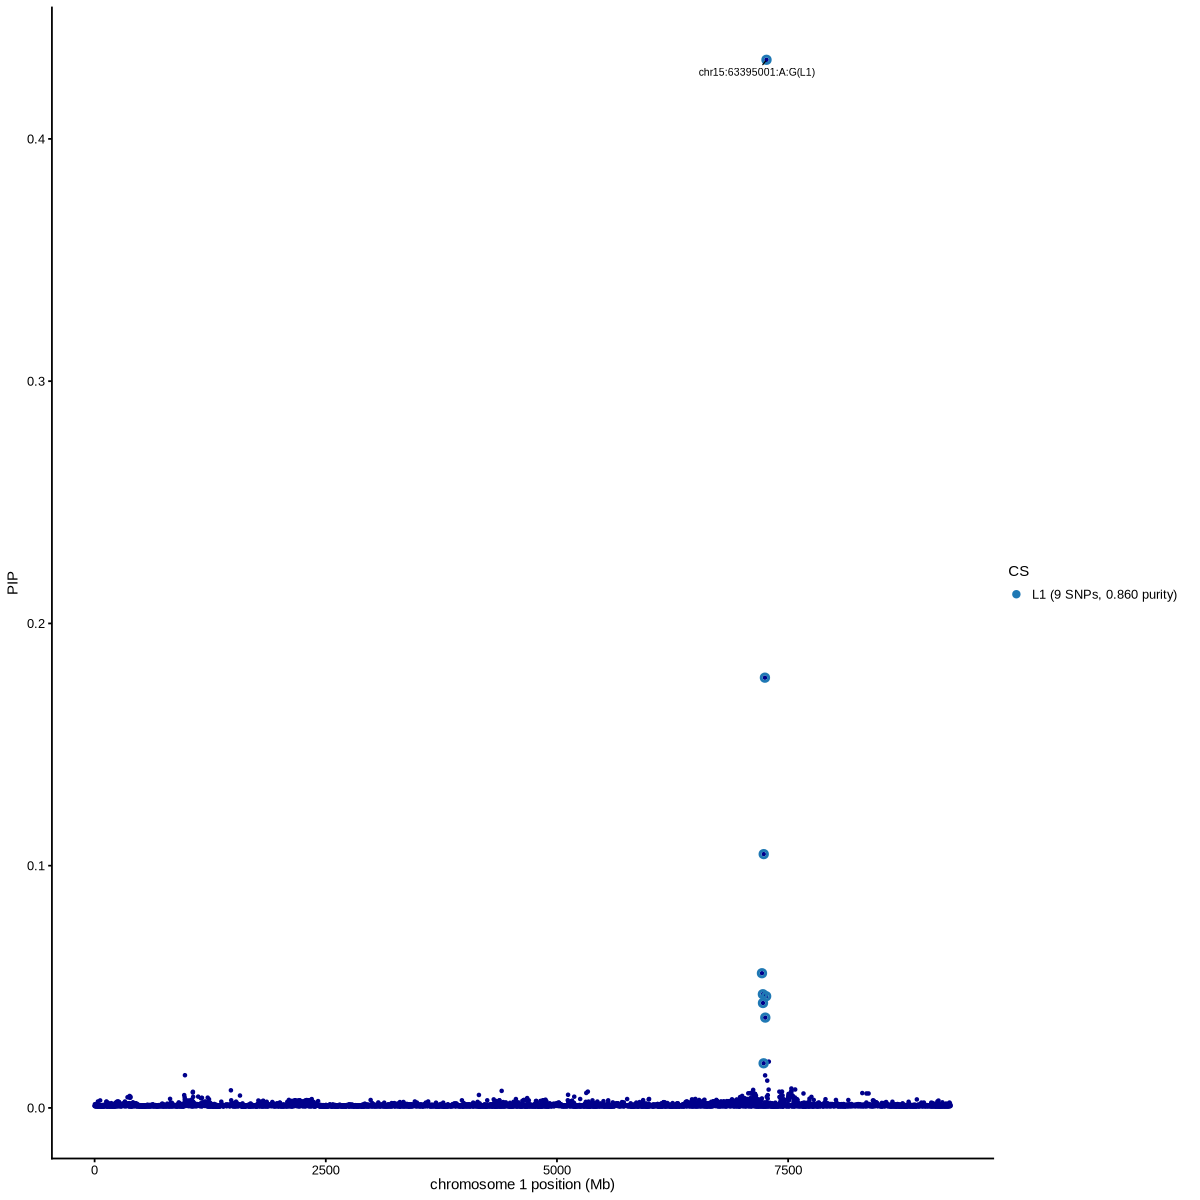

[1] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


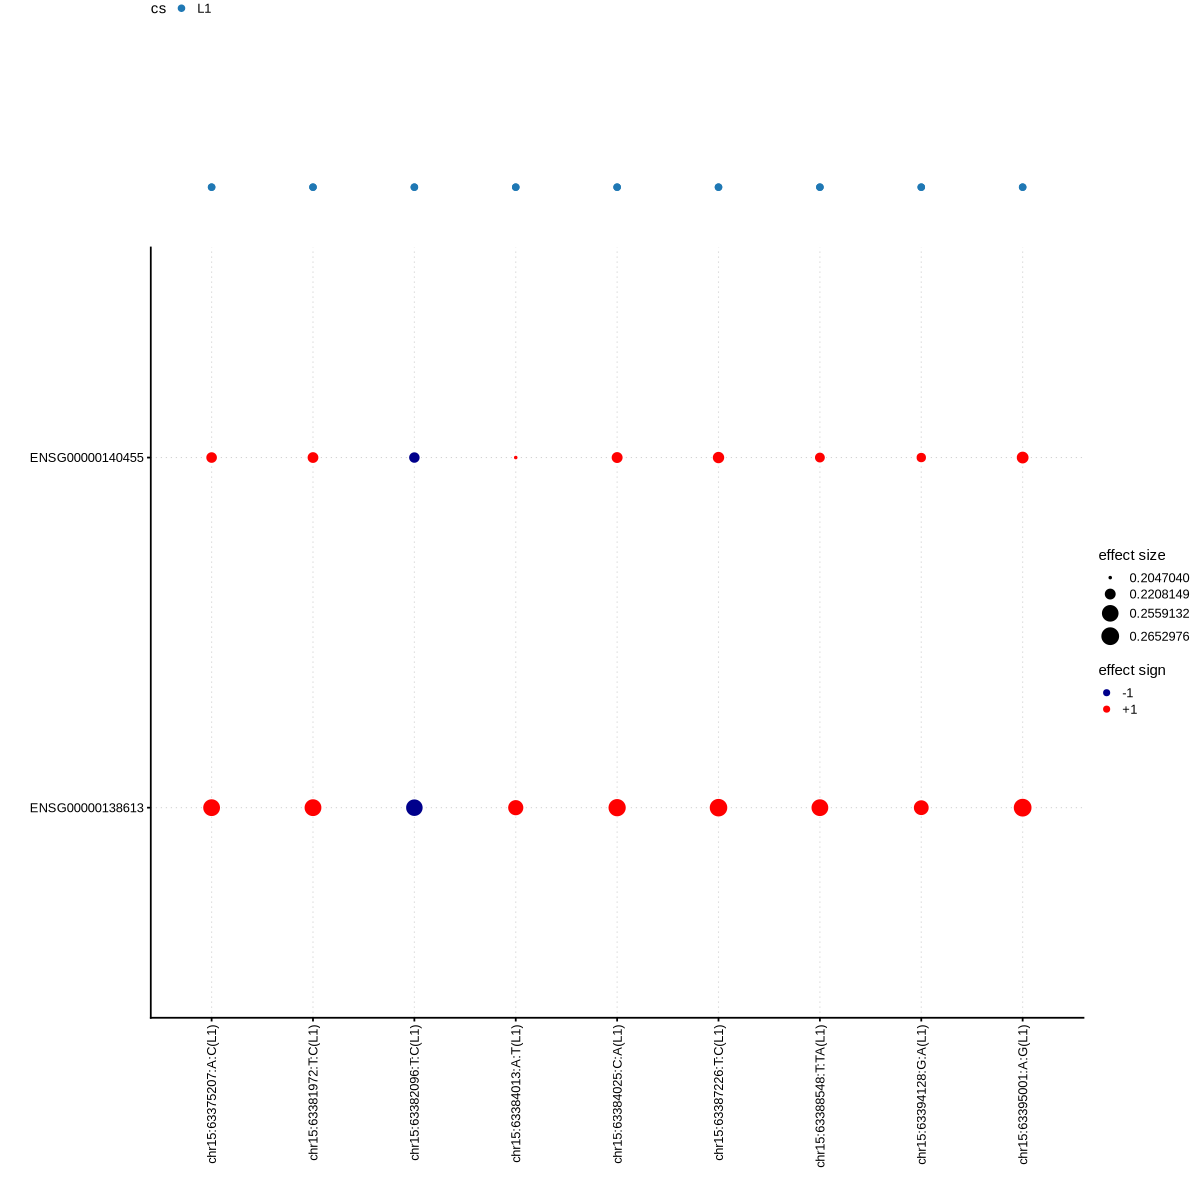

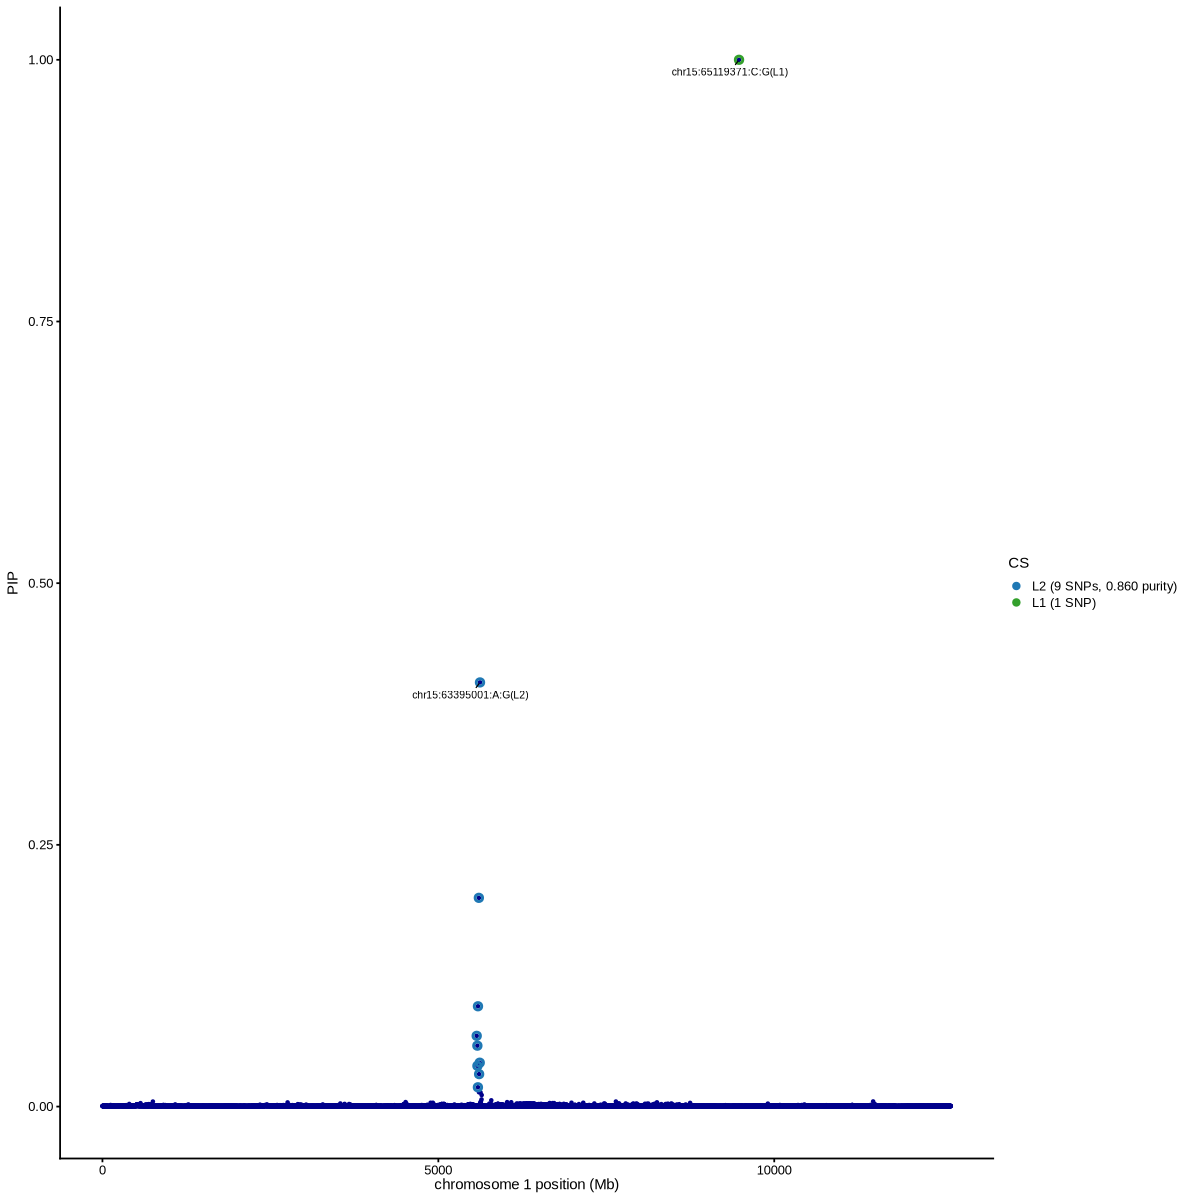

[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[2] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[3] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


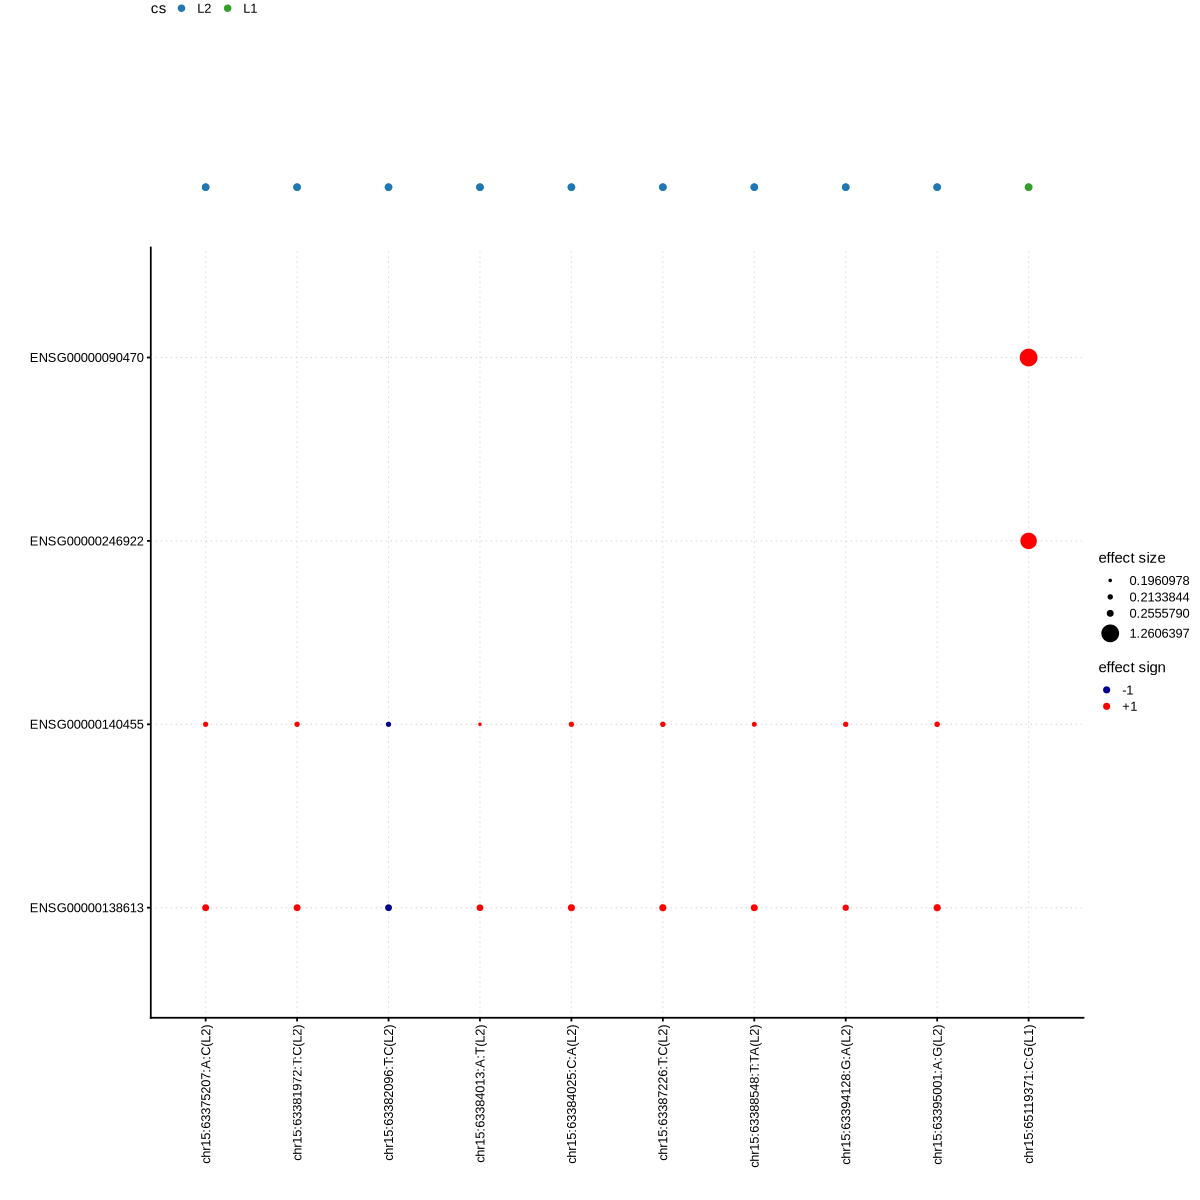

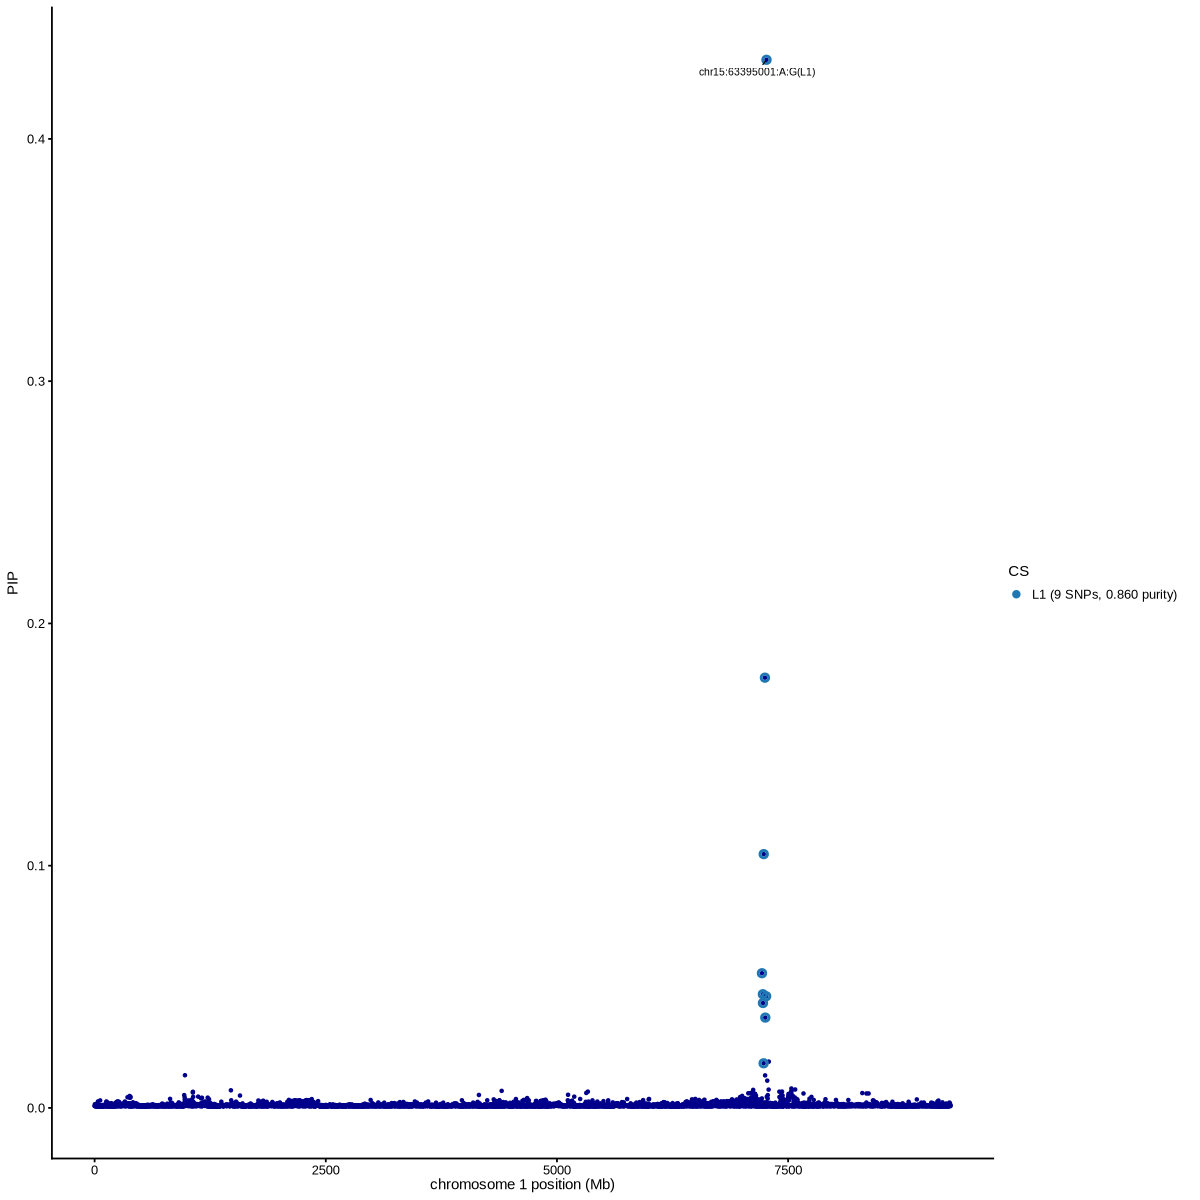

[1] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


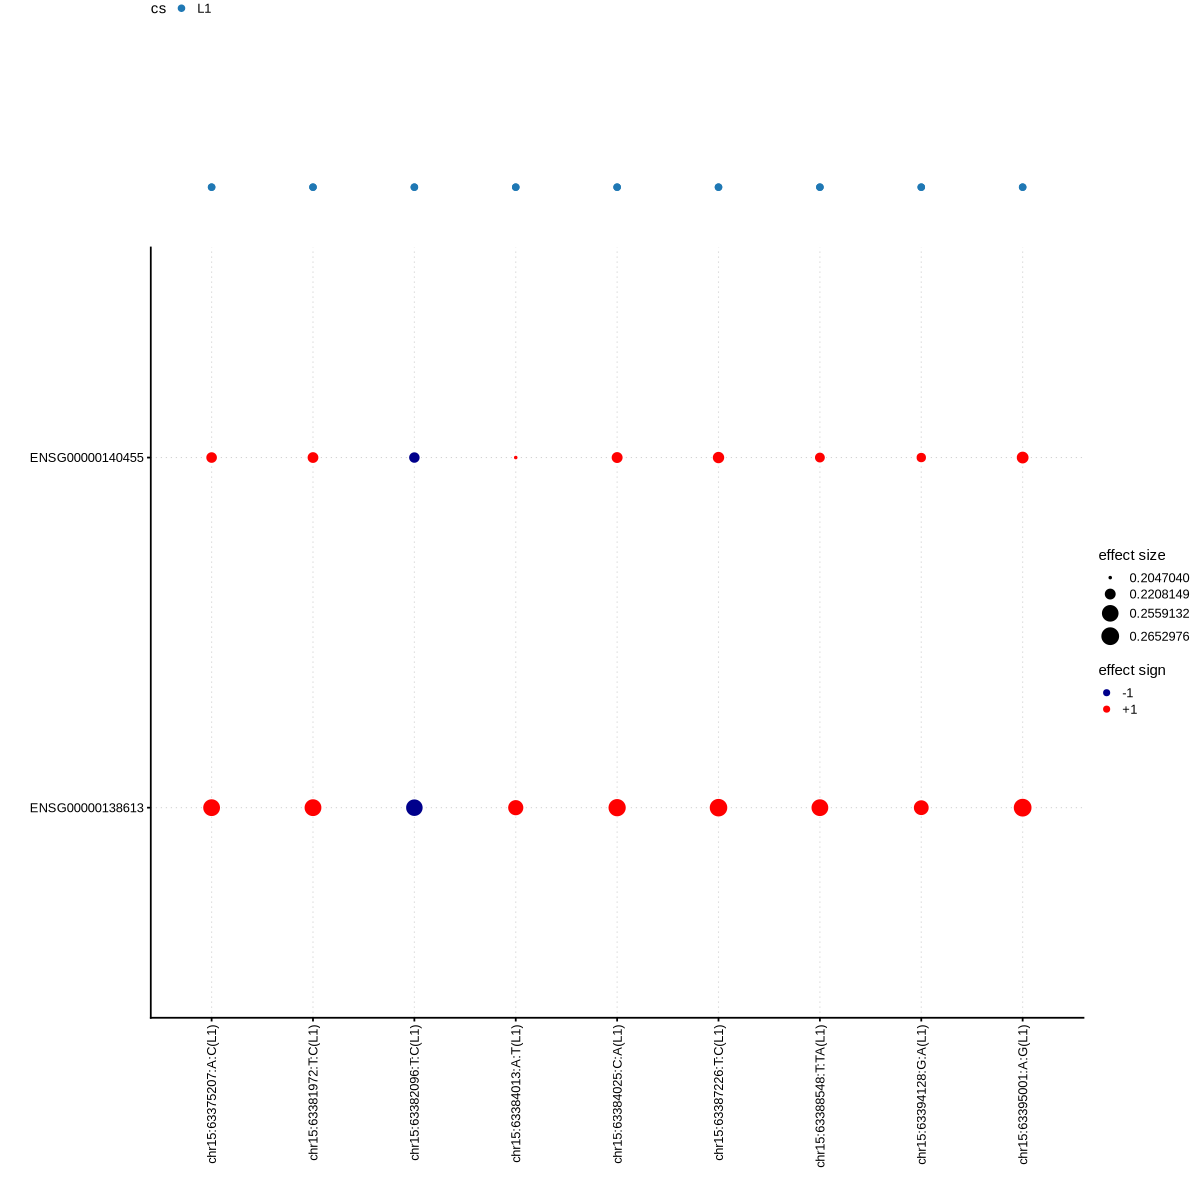

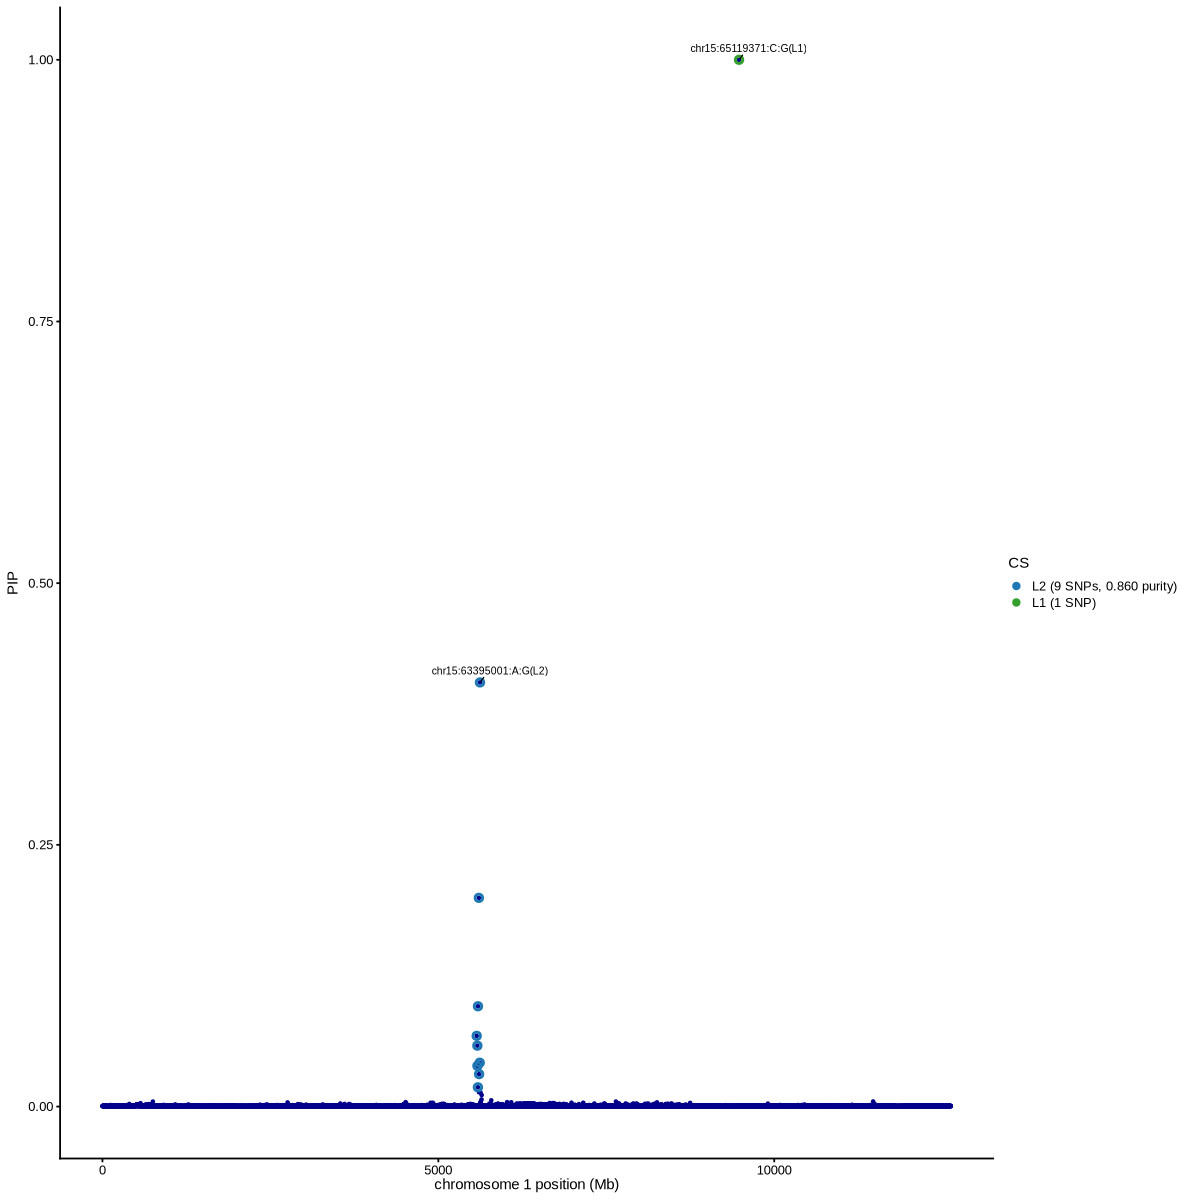

[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[2] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[3] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_58574103_63343138.multigene_bvrs.rds"
[1] "./ROSMAP_OPC_mega_eQTL.chr15_60834681_64158021.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


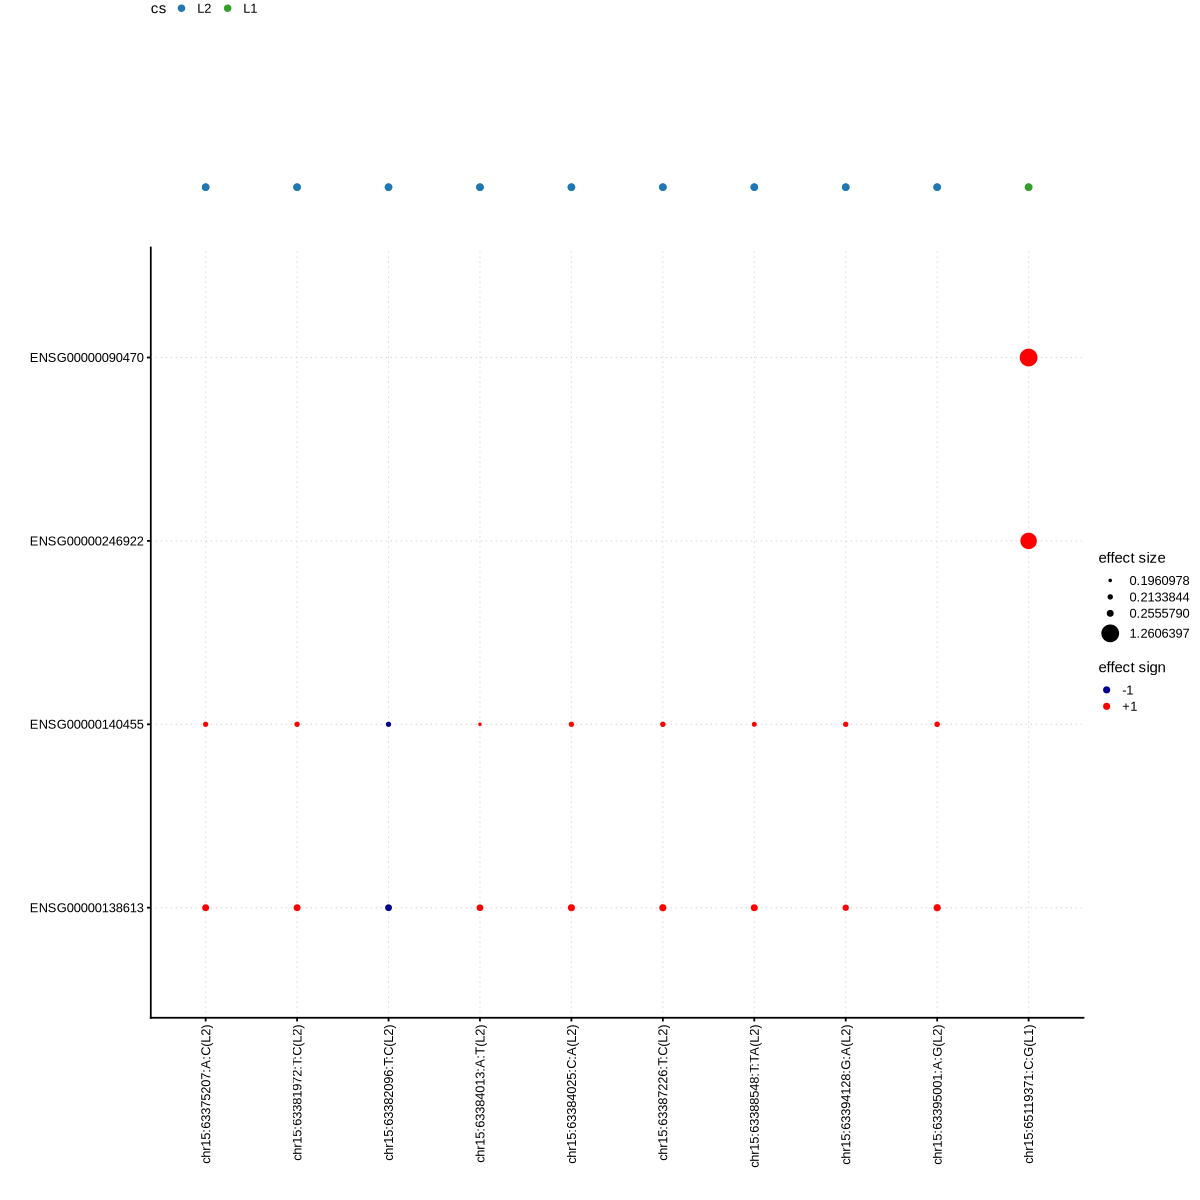

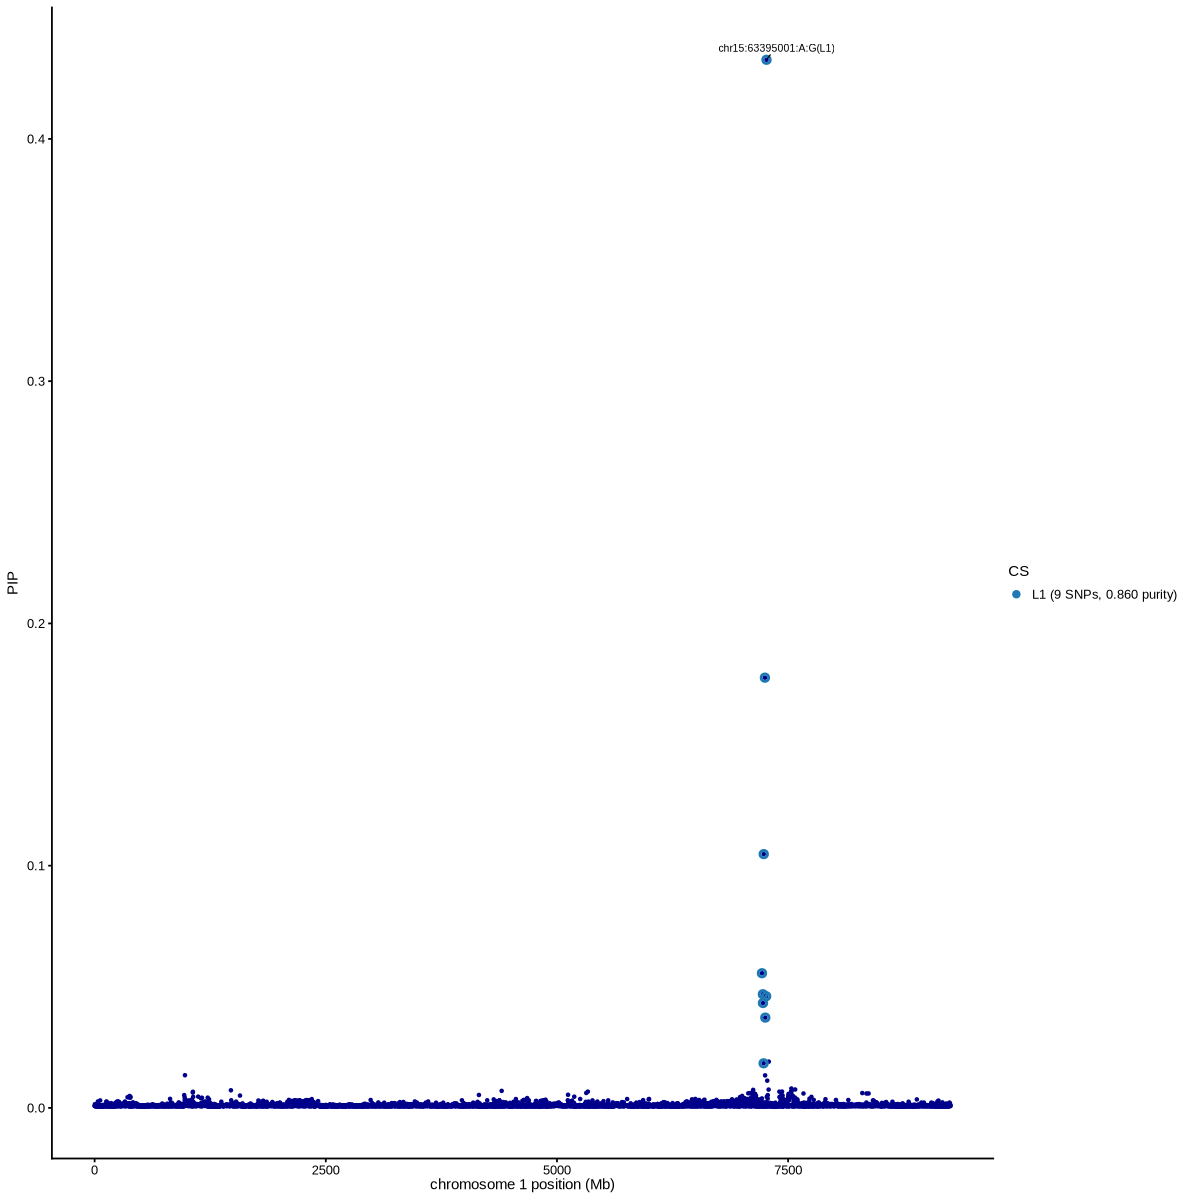

[1] "./ROSMAP_OPC_mega_eQTL.chr15_61390525_66517704.multigene_bvrs.rds"
[1] "ROSMAP_OPC_mega_eQTL"


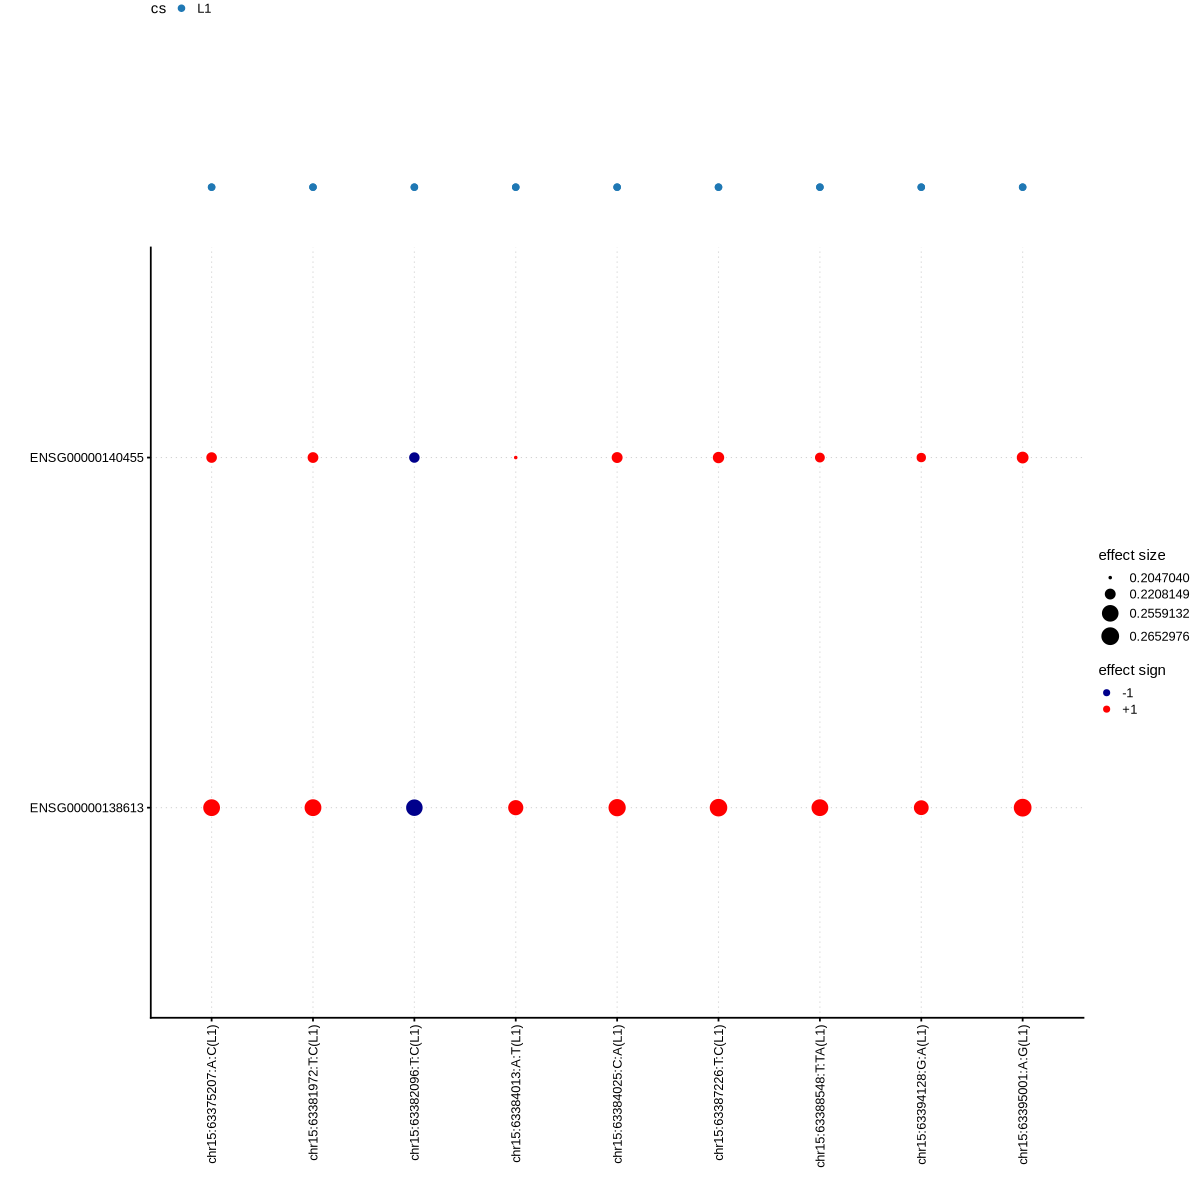

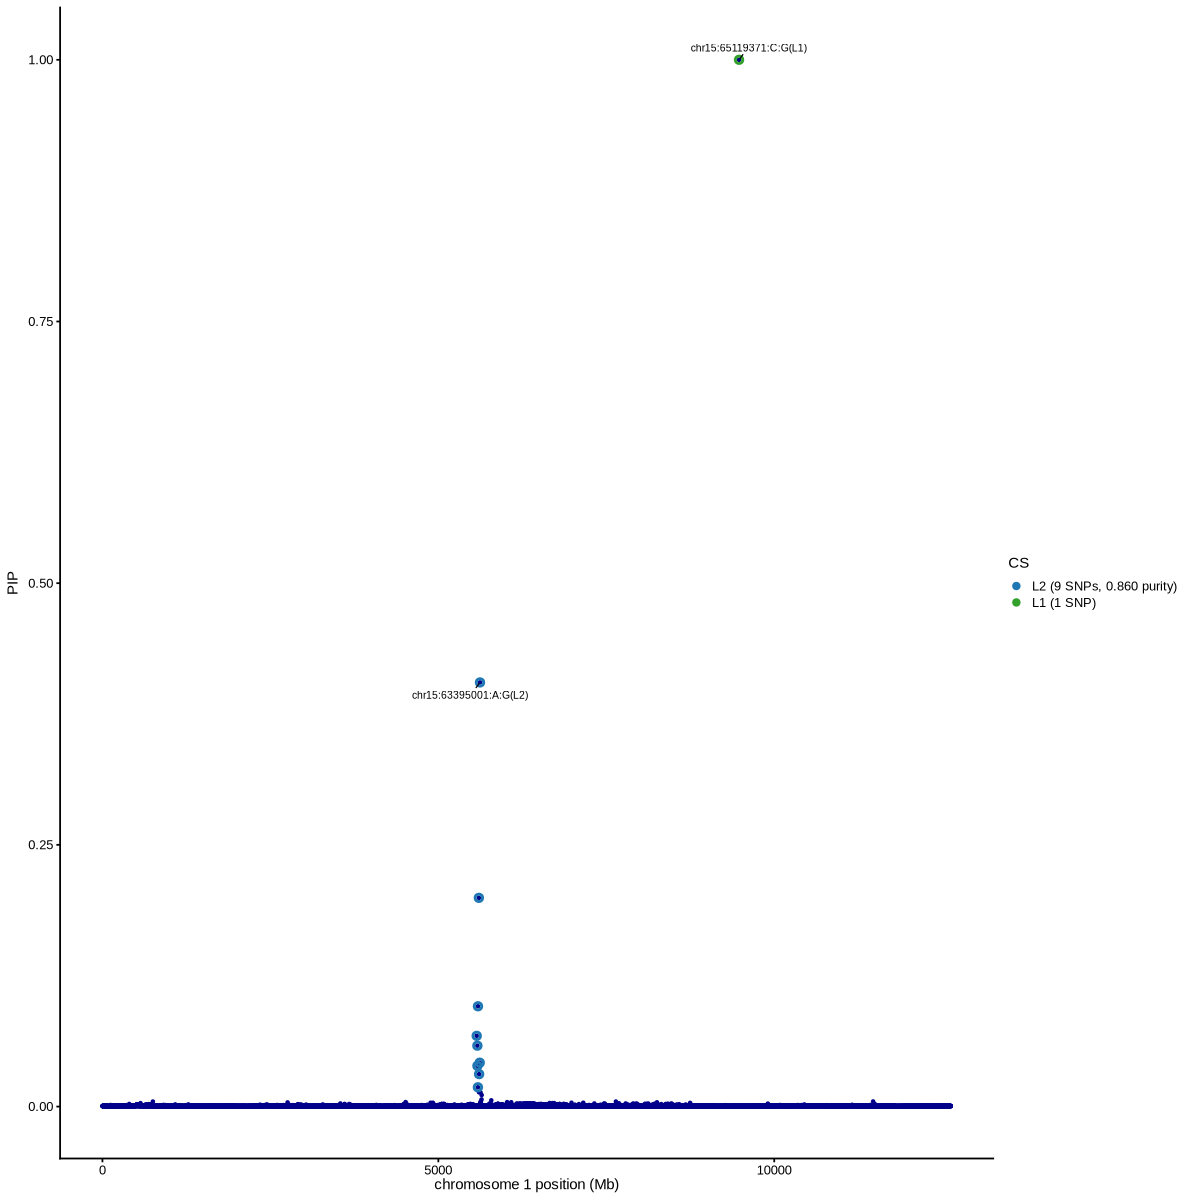

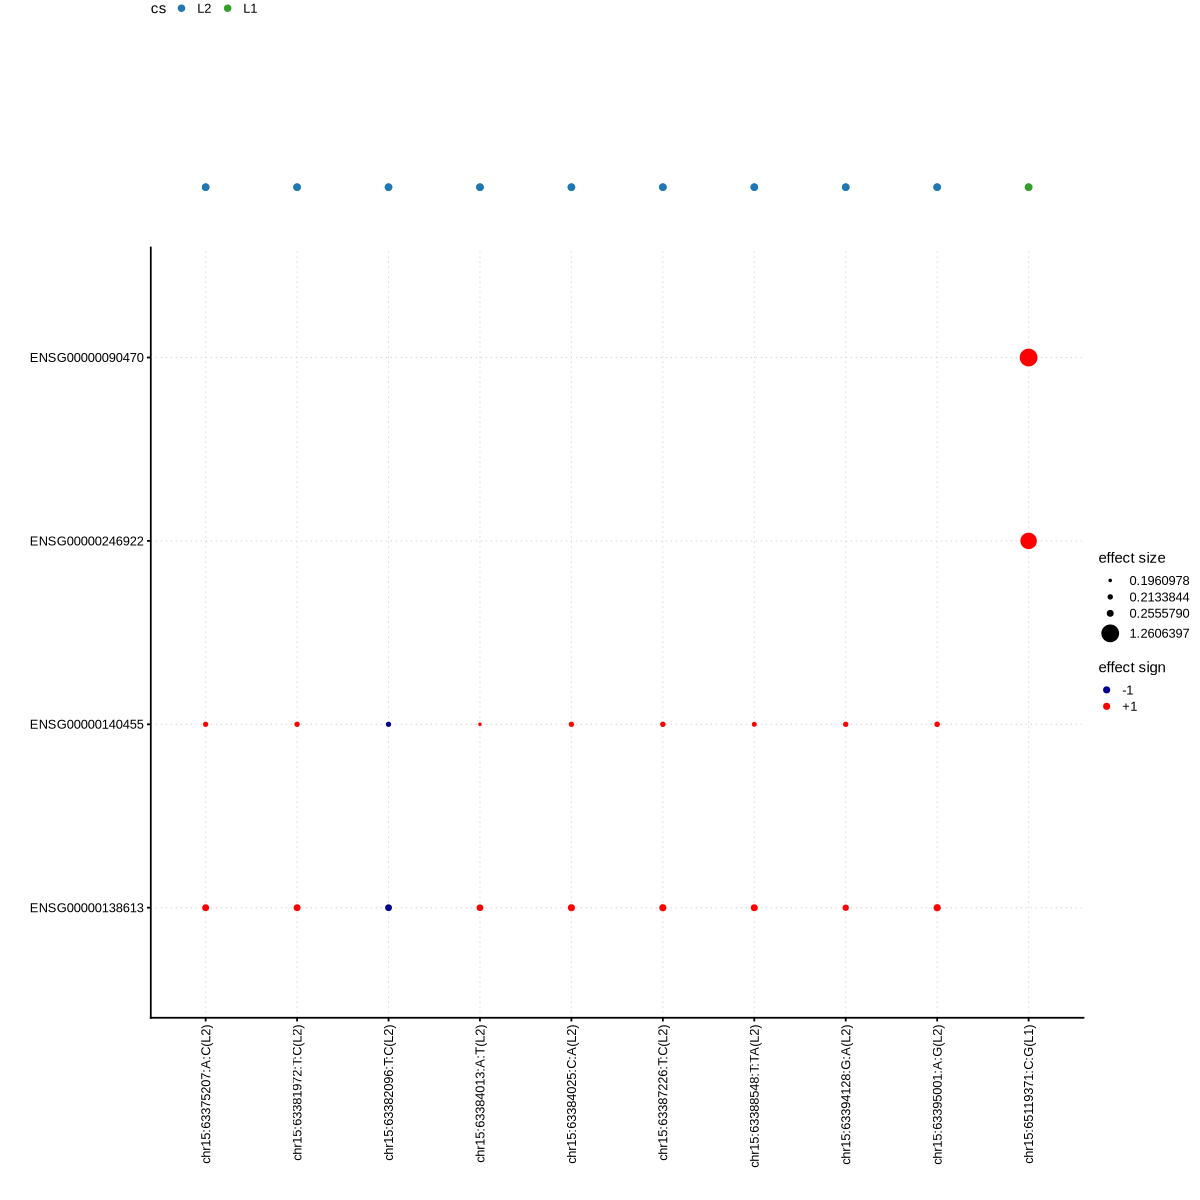

In [58]:
# Main loop to process sliding windows
options(repr.plot.width = 10, repr.plot.height = 10)
mnm_gene <- list()
for (window in sliding_windows) {
    context_files <- list.files(full.names = T) %>% .[str_detect(., '.multigene_bvrs.rds')]
    print(context_files)
    for(context_file in context_files){
        print(context_file)
        context_mnm <- context_file %>% basename %>% str_split(., '[.]', simplify = T) %>% .[,1]
        # Load multi-gene data
        mnm_gene_tmp <- tryCatch(
            readRDS(context_file),
            error = function(e) NULL
        )
        
        if (!is.null(mnm_gene_tmp)) {
            # Check if target gene is in the condition names
            if (target_gene_info$gene_info$region_id %in% mnm_gene_tmp[[1]]$mvsusie_fitted$condition_names) {
                # Use a common prefix format for multi-gene plots
                print(context_mnm)
                plot_and_save(mnm_gene_tmp[[1]], file.path(out, paste0('3d_', gene_name, '_multigene')))
            } else {
                message('There is mnm result for TAD window ', window, ' in ', context_mnm,
                        ', but it does not include target gene ', gene_name, ' in CS.')
            }
            # Append to the results list
            mnm_gene <- append(mnm_gene, list(mnm_gene_tmp))
        } 
    }
}

## Polish Version

In [51]:
# Calculate global x-axis limits across all plots
all_positions <- c(
  effect_of_interest_grid$grid_positions,
  effect_of_interest_mark$epi_mark_positions,
  tar_gene_info$gene_info$gene_start,
  tar_gene_info$gene_info$gene_end
)
xlim_range <- c(min(all_positions, na.rm = TRUE), max(all_positions, na.rm = TRUE))


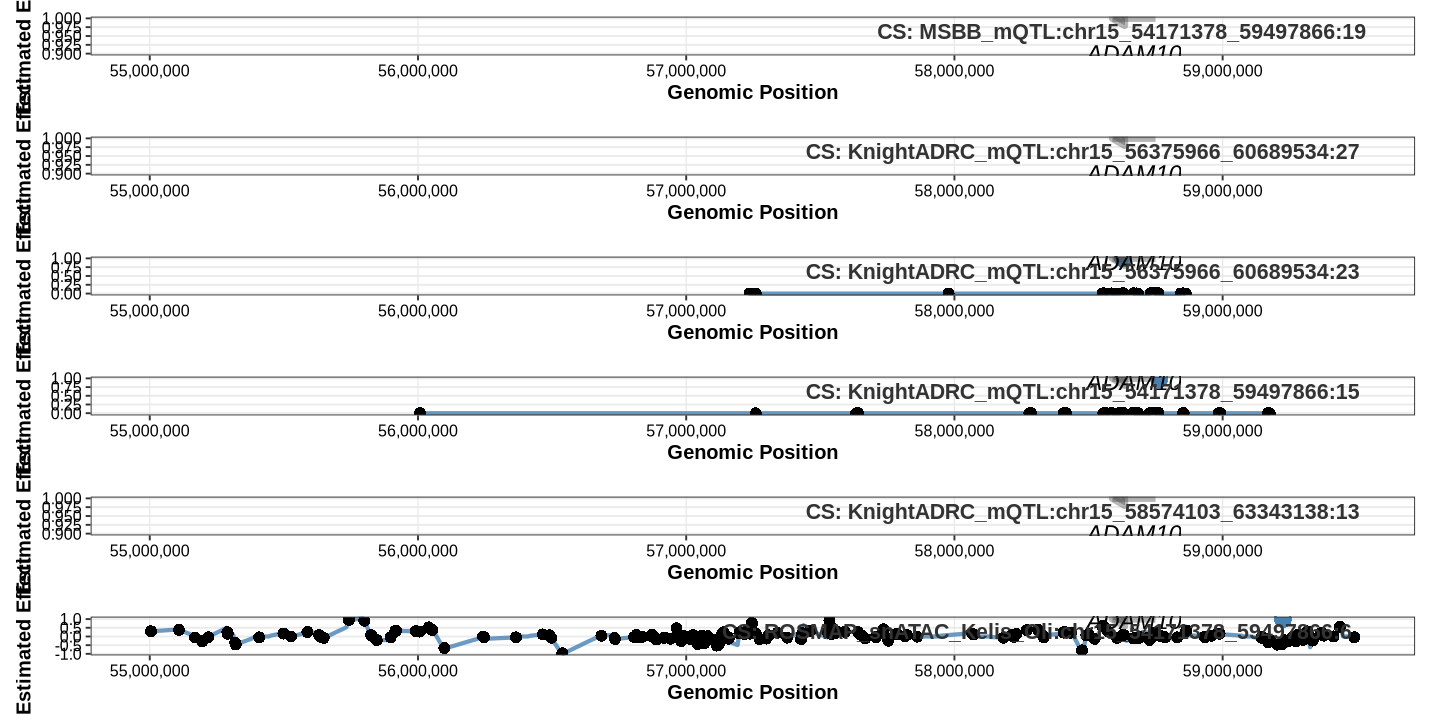

In [52]:
plots <- pmap(keys, function(cs_id, context, gene_ID) {
  cs_id1 <- cs_id
  
  # Filter data
  d_grid <- filter(effect_of_interest_grid, cs_id == cs_id1, context == context, gene_ID == gene_ID)
  d_mark <- filter(effect_of_interest_mark, cs_id == cs_id1, context == context, gene_ID == gene_ID)
  ginfo <- filter(tar_gene_info$gene_info, gene_ID == gene_ID)
  
  vlines <- flatten_table %>%
    filter(str_detect(context, "AD_"), cs_coverage_0.95 != 0) %>%
    mutate(AD_context = str_replace_all(context, "_", "\n")) %>%
    select(-context, -gene_ID, -cs_coverage_0.95)
  
  # Create plot with cs_id as title annotation
  p <- ggplot() +
    # Line showing grid effects
    geom_line(data = d_grid, aes(x = grid_positions, y = grid_effects), 
              linewidth = 1.2, color = "steelblue", alpha = 0.8) +
    
    # Points for epigenetic marks
    geom_point(data = d_mark, aes(x = epi_mark_positions, y = epi_mark_effects), 
               color = "black", size = 3, shape = 16) +
    
    # PIP values as points
    geom_point(data = d_grid, aes(x = end, y = PIP), 
               size = 4, color = "steelblue", alpha = 0.7) +
    
    # Gene annotation arrow
    geom_segment(data = ginfo, 
                 aes(x = gene_start, xend = gene_end, y = 1, yend = 1),
                 arrow = arrow(length = unit(0.3, "cm"), type = "closed"), 
                 linewidth = 2, alpha = 0.4, color = "gray30") +
    
    # Gene name label
    geom_text(data = ginfo, 
              aes(x = (gene_start + gene_end) / 2, y = 0.9, label = gene_name), 
              size = 5, fontface = "italic") +
    
    # Vertical reference lines
    geom_vline(data = vlines, aes(xintercept = end), 
               color = "red", alpha = 0.4, linetype = "dashed", linewidth = 0.5) +
    
    # Add cs_id label in top-right corner
    annotate("text", x = Inf, y = Inf, 
             label = paste0("CS: ", cs_id1), 
             hjust = 1.1, vjust = 1.5, size = 4.5, fontface = "bold", color = "gray20") +
    
    # Consistent x-axis limits
    coord_cartesian(xlim = xlim_range) +
    
    # Styling
    scale_x_continuous(labels = scales::comma) +
    labs(x = "Genomic Position", y = "Estimated Effect") +
    theme_bw(base_size = 12) +
    theme(
      panel.grid.minor = element_blank(),
      panel.grid.major.x = element_line(color = "gray90", linewidth = 0.3),
      axis.text = element_text(color = "black"),
      axis.title = element_text(face = "bold"),
      plot.margin = margin(10, 15, 10, 10)
    )
  
  return(p)
})

# Combine plots
p1 <- cowplot::plot_grid(plotlist = plots, ncol = 1, align = "v")


options(repr.plot.width = 12, repr.plot.height = 6)
p1
ggsave(file.path(out, "p1.png"), p1, width = 12, height = 9, dpi = 300)